# Microsoft Malware Detection


__Goal:__ Predict a Windows machine’s probability of getting infected by various families of malware, based on different properties of that machine. It is really important to find out whether the computer is infected and cure it.




![](https://storage.googleapis.com/kaggle-competitions/kaggle/10683/logos/thumb76_76.png?t=2018-09-19-16-55-15)

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !unzip '/content/drive/MyDrive/Machine Learning Projects/Microsoft_Malware_Detection_Codes/malware_df.csv.zip'

Archive:  /content/drive/MyDrive/Machine Learning Projects/Microsoft_Malware_Detection_Codes/malware_df.csv.zip
  inflating: train.csv               


## 1. Setup Environment

- Install the required packages
- Import all the packages in 1st cell itself
- Set the options for data visualizations

In [ ]:
# !pip install "ipywidgets>=7.6"
# !pip install plotly

In [3]:
# Data Manipulation
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

# Track time
import time
import datetime

# Machine Learning
from   sklearn.preprocessing import LabelEncoder
from   sklearn.model_selection import train_test_split, GridSearchCV
from   sklearn.metrics import confusion_matrix , classification_report, accuracy_score, roc_auc_score, precision_recall_curve
from   sklearn.linear_model import LogisticRegression
from   sklearn.tree import DecisionTreeClassifier
from   sklearn.ensemble import RandomForestClassifier
from   xgboost import XGBClassifier
from   lightgbm import LGBMClassifier
from   scipy.stats import chi2_contingency, f_oneway


import gc
import warnings
from   tqdm import tqdm_notebook
import ipywidgets


# Set Options
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
%matplotlib inline
plt.style.use('ggplot')
py.init_notebook_mode(connected=False) # To work offline
warnings.filterwarnings("ignore")

Output hidden; open in https://colab.research.google.com to view.

##  2. Data Overview

The goal of this section is to :
- Load the malware dataset
- Explore the features

Load the malware dataset using `pd.read_csv()`. File size is huge, so let's work on half data only i.e. 4000000 rows

In [4]:
%%time
nrows = 10000  # reduce if needed
train = pd.read_csv('/content/train.csv',
                    nrows = nrows)

CPU times: user 191 ms, sys: 47.4 ms, total: 239 ms
Wall time: 345 ms


In [5]:
# Export. Make sure 'Data/Intermediate' exists.
#train.to_csv('train2.csv')

In [6]:
train.head(5)

MachineIdentifier   ProductName EngineVersion  \
0  0000028988387b115f69f31a3bf04f09  win8defender   1.1.15100.1   
1  000007535c3f730efa9ea0b7ef1bd645  win8defender   1.1.14600.4   
2  000007905a28d863f6d0d597892cd692  win8defender   1.1.15100.1   
3  00000b11598a75ea8ba1beea8459149f  win8defender   1.1.15100.1   
4  000014a5f00daa18e76b81417eeb99fc  win8defender   1.1.15100.1   

        AppVersion  AvSigVersion  IsBeta  RtpStateBitfield  IsSxsPassiveMode  \
0  4.18.1807.18075  1.273.1735.0       0               7.0                 0   
1     4.13.17134.1    1.263.48.0       0               7.0                 0   
2  4.18.1807.18075  1.273.1341.0       0               7.0                 0   
3  4.18.1807.18075  1.273.1527.0       0               7.0                 0   
4  4.18.1807.18075  1.273.1379.0       0               7.0                 0   

   DefaultBrowsersIdentifier  AVProductStatesIdentifier  AVProductsInstalled  \
0                        NaN                    53447.0                  1.0   
1                        NaN                    53447.0                  1.0   
2                        NaN                    53447.0                  1.0   
3                        NaN                    53447.0                  1.0   
4                        NaN                    53447.0                  1.0   

   AVProductsEnabled  HasTpm  CountryIdentifier  CityIdentifier  \
0                1.0       1                 29        128035.0   
1                1.0       1                 93          1482.0   
2                1.0       1                 86        153579.0   
3                1.0       1                 88         20710.0   
4                1.0       1                 18         37376.0   

   OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  \
0                    18.0                 35                          171   
1                    18.0                119                           64   
2                    18.0                 64                           49   
3                     NaN                117                          115   
4                     NaN                277                           75   

    Platform Processor     OsVer  OsBuild  OsSuite OsPlatformSubRelease  \
0  windows10       x64  10.0.0.0    17134      256                  rs4   
1  windows10       x64  10.0.0.0    17134      256                  rs4   
2  windows10       x64  10.0.0.0    17134      768                  rs4   
3  windows10       x64  10.0.0.0    17134      256                  rs4   
4  windows10       x64  10.0.0.0    17134      768                  rs4   

                                 OsBuildLab SkuEdition  IsProtected  \
0  17134.1.amd64fre.rs4_release.180410-1804        Pro          1.0   
1  17134.1.amd64fre.rs4_release.180410-1804        Pro          1.0   
2  17134.1.amd64fre.rs4_release.180410-1804       Home          1.0   
3  17134.1.amd64fre.rs4_release.180410-1804        Pro          1.0   
4  17134.1.amd64fre.rs4_release.180410-1804       Home          1.0   

   AutoSampleOptIn PuaMode  SMode  IeVerIdentifier   SmartScreen  Firewall  \
0                0     NaN    0.0            137.0           NaN       1.0   
1                0     NaN    0.0            137.0           NaN       1.0   
2                0     NaN    0.0            137.0  RequireAdmin       1.0   
3                0     NaN    0.0            137.0  ExistsNotSet       1.0   
4                0     NaN    0.0            137.0  RequireAdmin       1.0   

   UacLuaenable Census_MDC2FormFactor Census_DeviceFamily  \
0           1.0               Desktop     Windows.Desktop   
1           1.0              Notebook     Windows.Desktop   
2           1.0               Desktop     Windows.Desktop   
3           1.0               Desktop     Windows.Desktop   
4           1.0              Notebook     Windows.Desktop   

   Census_OEMNameIdentifier  Census_OEMModelIdentifier  \
0              

### Data Description

The telemetry data containing these properties and the machine infections was generated by combining heartbeat and threat reports collected by Microsoft's endpoint protection solution, Windows Defender.

Each row in this dataset corresponds to a machine, uniquely identified by a MachineIdentifier. HasDetections is the ground truth and indicates that Malware was detected on the machine.


The sampling methodology used to create this dataset was designed to meet certain business constraints, both in regards to user privacy as well as the time period during which the machine was running. Malware detection is inherently a time-series problem, but it is made complicated by the introduction of new machines, machines that come online and offline, machines that receive patches, machines that receive new operating systems, etc. Additionally, this dataset is not representative of Microsoft customers’ machines in the wild; it has been sampled to include a much larger proportion of malware machines.
Columns


Unavailable or self-documenting column names are marked with an "NA".
1.	__MachineIdentifier__ - Individual machine ID
2.	__ProductName__ - Defender state information e.g. win8defender
3.	__EngineVersion__ - Defender state information e.g. 1.1.12603.0
4.	__AppVersion__ - Defender state information e.g. 4.9.10586.0
5.	__AvSigVersion__ - Defender state information e.g. 1.217.1014.0
6.	__IsBeta__ - Defender state information e.g. false
7.	__RtpStateBitfield__ - NA
8.	__IsSxsPassiveMode__ - NA
9.	__DefaultBrowsersIdentifier__ - ID for the machine's default browser
10.	__AVProductStatesIdentifier__ - ID for the specific configuration of a user's antivirus software
11.	__AVProductsInstalled__ - NA
12.	__AVProductsEnabled__ - NA
13.	__HasTpm__ - True if machine has tpm
14.	__CountryIdentifier__ - ID for the country the machine is located in
15.	__CityIdentifier__ - ID for the city the machine is located in
16.	__OrganizationIdentifier__ - ID for the organization the machine belongs in, organization ID is mapped to both specific companies and broad industries
17.	__GeoNameIdentifier__ - ID for the geographic region a machine is located in
18.	__LocaleEnglishNameIdentifier__ - English name of Locale ID of the current user
19.	__Platform__ - Calculates platform name (of OS related properties and processor property)
20.	__Processor__ - This is the process architecture of the installed operating system
21.	__OsVer__ - Version of the current operating system
22.	__OsBuild__ - Build of the current operating system
23.	__OsSuite__ - Product suite mask for the current operating system.
24.	__OsPlatformSubRelease__ - Returns the OS Platform sub-release (Windows Vista, Windows 7, Windows 8, TH1, TH2)
25.	__OsBuildLab__ - Build lab that generated the current OS. Example: 9600.17630.amd64fre.winblue_r7.150109-2022
26.	__SkuEdition__ - The goal of this feature is to use the Product Type defined in the MSDN to map to a 'SKU-Edition' name that is useful in population reporting. The valid Product Type are defined in %sdxroot%\data\windowseditions.xml. This API has been used since Vista and Server 2008, so there are many Product Types that do not apply to Windows 10. The 'SKU-Edition' is a string value that is in one of three classes of results. The design must hand each class.
27.	__IsProtected__ - This is a calculated field derived from the Spynet Report's AV Products field. Returns: a. TRUE if there is at least one active and up-to-date antivirus product running on this machine. b. FALSE if there is no active AV product on this machine, or if the AV is active, but is not receiving the latest updates. c. null if there are no Anti Virus Products in the report. Returns: Whether a machine is protected.
28.	__AutoSampleOptIn__ - This is the SubmitSamplesConsent value passed in from the service, available on CAMP 9+
29.	__PuaMode__ - Pua Enabled mode from the service
30.	__SMode__ - This field is set to true when the device is known to be in 'S Mode', as in, Windows 10 S mode, where only Microsoft Store apps can be installed
31.	__IeVerIdentifier__ - NA
32.	__SmartScreen__ - This is the SmartScreen enabled string value from registry. This is obtained by checking in order, HKLM\SOFTWARE\Policies\Microsoft\Windows\System\SmartScreenEnabled and HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Explorer\SmartScreenEnabled. If the value exists but is blank, the value "ExistsNotSet" is sent in telemetry.
33.	__Firewall__ - This attribute is true (1) for Windows 8.1 and above if windows firewall is enabled, as reported by the service.
34.	__UacLuaenable__ - This attribute reports whether or not the "administrator in Admin Approval Mode" user type is disabled or enabled in UAC. The value reported is obtained by reading the regkey HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Policies\System\EnableLUA.
35.	vCensus_MDC2FormFactor - A grouping based on a combination of Device Census level hardware characteristics. The logic used to define Form Factor is rooted in business and industry standards and aligns with how people think about their device. (Examples: Smartphone, Small Tablet, All in One, Convertible…)
36.	__Census_DeviceFamily__ - AKA DeviceClass. Indicates the type of device that an edition of the OS is intended for. Example values: Windows.Desktop, Windows.Mobile, and iOS.Phone
37.	__Census_OEMNameIdentifier__ - NA
38.	__Census_OEMModelIdentifier__ - NA
39.	__Census_ProcessorCoreCount__ - Number of logical cores in the processor
40.	__Census_ProcessorManufacturerIdentifier__ - NA
41.	__Census_ProcessorModelIdentifier__ - NA
42.	__Census_ProcessorClass__ - A classification of processors into high/medium/low. Initially used for Pricing Level SKU. No longer maintained and updated
43.	__Census_PrimaryDiskTotalCapacity__ - Amount of disk space on primary disk of the machine in MB
44.	__Census_PrimaryDiskTypeName__ - Friendly name of Primary Disk Type - HDD or SSD
45.	__Census_SystemVolumeTotalCapacity__ - The size of the partition that the System volume is installed on in MB
46.	__Census_HasOpticalDiskDrive__ - True indicates that the machine has an optical disk drive (CD/DVD)
47.	__Census_TotalPhysicalRAM__ - Retrieves the physical RAM in MB
48.	__Census_ChassisTypeName__ - Retrieves a numeric representation of what type of chassis the machine has. A value of 0 means xx
49.	__Census_InternalPrimaryDiagonalDisplaySizeInInches__ - Retrieves the physical diagonal length in inches of the primary display
50.	__Census_InternalPrimaryDisplayResolutionHorizontal__ - Retrieves the number of pixels in the horizontal direction of the internal display.
51.	__Census_InternalPrimaryDisplayResolutionVertical__ - Retrieves the number of pixels in the vertical direction of the internal display
52.	__Census_PowerPlatformRoleName__ - Indicates the OEM preferred power management profile. This value helps identify the basic form factor of the device
53.	__Census_InternalBatteryType__ - NA
54.	__Census_InternalBatteryNumberOfCharges__ - NA
55.	__Census_OSVersion__ - Numeric OS version Example - 10.0.10130.0
56.	__Census_OSArchitecture__ - Architecture on which the OS is based. Derived from OSVersionFull. Example - amd64
57.	__Census_OSBranch__ - Branch of the OS extracted from the OsVersionFull. Example - OsBranch = fblpartnereeap where OsVersion = 6.4.9813.0.amd64fre.fblpartnereeap.140810-0005
58.	__Census_OSBuildNumber__ - OS Build number extracted from the OsVersionFull. Example - OsBuildNumber = 10512 or 10240
59.	__Census_OSBuildRevision__ - OS Build revision extracted from the OsVersionFull. Example - OsBuildRevision = 1000 or 16458
60.	__Census_OSEdition__ - Edition of the current OS. Sourced from HKLM\Software\Microsoft\Windows NT\CurrentVersion@EditionID in registry. Example: Enterprise
61.	__Census_OSSkuName__ - OS edition friendly name (currently Windows only)
62.	__Census_OSInstallTypeName__ - Friendly description of what install was used on the machine i.e. clean
63.	__Census_OSInstallLanguageIdentifie_r__ - NA
64.	__Census_OSUILocaleIdentifier__ - NA
65.	__Census_OSWUAutoUpdateOptionsName__ - Friendly name of the WindowsUpdate auto-update settings on the machine.
66.	__Census_IsPortableOperatingSystem__ - Indicates whether OS is booted up and running via Windows-To-Go on a USB stick.
67.	__Census_GenuineStateName__ - Friendly name of OSGenuineStateID. 0 = Genuine
68.	__Census_ActivationChannel__ - Retail license key or Volume license key for a machine.
69.	__Census_IsFlightingInternal__ - NA
70.	__Census_IsFlightsDisabled__ - Indicates if the machine is participating in flighting.
71.	__Census_FlightRing__ - The ring that the device user would like to receive flights for. This might be different from the ring of the OS which is currently installed if the user changes the ring after getting a flight from a different ring.
72.	__Census_ThresholdOptIn__ - NA
73.	__Census_FirmwareManufacturerIdentifier__ - NA
74.	__Census_FirmwareVersionIdentifier__ - NA
75.	__Census_IsSecureBootEnabled__ - Indicates if Secure Boot mode is enabled.
76.	__Census_IsWIMBootEnabled__ - NA
77.	__Census_IsVirtualDevice__ - Identifies a Virtual Machine (machine learning model)
78.	__Census_IsTouchEnabled__ - Is this a touch device ?
79.	__Census_IsPenCapable__ - Is the device capable of pen input ?
80.	__Census_IsAlwaysOnAlwaysConnectedCapable__ - Retreives information about whether the battery enables the device to be AlwaysOnAlwaysConnected .
81.	__Wdft_IsGamer__ - Indicates whether the device is a gamer device or not based on its hardware combination.
82.	__Wdft_RegionIdentifier__ - NA



##  3. Optimize Memory Used by Data

In [7]:
# As the dataset is quite large, let's optimise the memory utilisation of the dataframe.
# Calculate total memory usage of the train DataFrame in megabytes (MB).
round(train.memory_usage(deep=True).sum() / 1024**2, 2)

22.39

In [8]:
train.dtypes

MachineIdentifier                                     object
ProductName                                           object
EngineVersion                                         object
AppVersion                                            object
AvSigVersion                                          object
IsBeta                                                 int64
RtpStateBitfield                                     float64
IsSxsPassiveMode                                       int64
DefaultBrowsersIdentifier                            float64
AVProductStatesIdentifier                            float64
AVProductsInstalled                                  float64
AVProductsEnabled                                    float64
HasTpm                                                 int64
CountryIdentifier                                      int64
CityIdentifier                                       float64
OrganizationIdentifier                               float64
GeoNameIdentifier       

Certain features occupy more memory than what is needed to store them. Reducing the memory usage by changing data type will speed up the computations.

Let's create a function for that:

- int8 / uint8 : consumes 1 byte of memory, range between -128/127 or 0/255
- bool : consumes 1 byte, true or false
- float16 / int16 / uint16: consumes 2 bytes of memory, range between -32768 and 32767 or 0/65535
- float32 / int32 / uint32 : consumes 4 bytes of memory, range between -2147483648 and 2147483647
- float64 / int64 / uint64: consumes 8 bytes of memory

In [9]:
print('int64 min: ', np.iinfo(np.int64).min)
print('int64 max: ', np.iinfo(np.int64).max)

int64 min:  -9223372036854775808
int64 max:  9223372036854775807


In [10]:
print('int8 min: ', np.iinfo(np.int8).min)
print('int8 max: ', np.iinfo(np.int8).max)

int8 min:  -128
int8 max:  127


In [11]:
# # Reduce memory usage
# def reduce_mem_usage(df, verbose=True):
#     numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#     start_mem = df.memory_usage(deep=True).sum() / 1024**2
#     for col in df.columns:
#         col_type = df[col].dtypes
#         if col_type in numerics:
#             c_min = df[col].min()
#             c_max = df[col].max()
#             if str(col_type)[:3] == 'int':
#                 if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                     df[col] = df[col].astype(np.int8)
#                 elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                     df[col] = df[col].astype(np.int16)
#                 elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
#                     df[col] = df[col].astype(np.int32)
#                 elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
#                     df[col] = df[col].astype(np.int64)
#             else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     df[col] = df[col].astype(np.float32)
#                 else:
#                     df[col] = df[col].astype(np.float64)
#     end_mem = df.memory_usage(deep=True).sum() / 1024**2
#     if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
#     return df

Use the defined function to reduce the memory usage

In [12]:
# Reduce the memory size of the dataframe
# train = reduce_mem_usage(train)

##  4. Understand the Data

Before attempting to solve the problem, it's very important to have a good understanding of data.

The goal of this section is to:
- Get the dimensions of data
- Get the summary of data
- Get various statistics of data

#### Shape of dataframe

In [13]:
# Shape of dataframe
train.shape

(10000, 83)

The dataset has 4 million rows and 83 columns

In [14]:
# Head of train df
train.head()

MachineIdentifier   ProductName EngineVersion  \
0  0000028988387b115f69f31a3bf04f09  win8defender   1.1.15100.1   
1  000007535c3f730efa9ea0b7ef1bd645  win8defender   1.1.14600.4   
2  000007905a28d863f6d0d597892cd692  win8defender   1.1.15100.1   
3  00000b11598a75ea8ba1beea8459149f  win8defender   1.1.15100.1   
4  000014a5f00daa18e76b81417eeb99fc  win8defender   1.1.15100.1   

        AppVersion  AvSigVersion  IsBeta  RtpStateBitfield  IsSxsPassiveMode  \
0  4.18.1807.18075  1.273.1735.0       0               7.0                 0   
1     4.13.17134.1    1.263.48.0       0               7.0                 0   
2  4.18.1807.18075  1.273.1341.0       0               7.0                 0   
3  4.18.1807.18075  1.273.1527.0       0               7.0                 0   
4  4.18.1807.18075  1.273.1379.0       0               7.0                 0   

   DefaultBrowsersIdentifier  AVProductStatesIdentifier  AVProductsInstalled  \
0                        NaN                    53447.0                  1.0   
1                        NaN                    53447.0                  1.0   
2                        NaN                    53447.0                  1.0   
3                        NaN                    53447.0                  1.0   
4                        NaN                    53447.0                  1.0   

   AVProductsEnabled  HasTpm  CountryIdentifier  CityIdentifier  \
0                1.0       1                 29        128035.0   
1                1.0       1                 93          1482.0   
2                1.0       1                 86        153579.0   
3                1.0       1                 88         20710.0   
4                1.0       1                 18         37376.0   

   OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  \
0                    18.0                 35                          171   
1                    18.0                119                           64   
2                    18.0                 64                           49   
3                     NaN                117                          115   
4                     NaN                277                           75   

    Platform Processor     OsVer  OsBuild  OsSuite OsPlatformSubRelease  \
0  windows10       x64  10.0.0.0    17134      256                  rs4   
1  windows10       x64  10.0.0.0    17134      256                  rs4   
2  windows10       x64  10.0.0.0    17134      768                  rs4   
3  windows10       x64  10.0.0.0    17134      256                  rs4   
4  windows10       x64  10.0.0.0    17134      768                  rs4   

                                 OsBuildLab SkuEdition  IsProtected  \
0  17134.1.amd64fre.rs4_release.180410-1804        Pro          1.0   
1  17134.1.amd64fre.rs4_release.180410-1804        Pro          1.0   
2  17134.1.amd64fre.rs4_release.180410-1804       Home          1.0   
3  17134.1.amd64fre.rs4_release.180410-1804        Pro          1.0   
4  17134.1.amd64fre.rs4_release.180410-1804       Home          1.0   

   AutoSampleOptIn PuaMode  SMode  IeVerIdentifier   SmartScreen  Firewall  \
0                0     NaN    0.0            137.0           NaN       1.0   
1                0     NaN    0.0            137.0           NaN       1.0   
2                0     NaN    0.0            137.0  RequireAdmin       1.0   
3                0     NaN    0.0            137.0  ExistsNotSet       1.0   
4                0     NaN    0.0            137.0  RequireAdmin       1.0   

   UacLuaenable Census_MDC2FormFactor Census_DeviceFamily  \
0           1.0               Desktop     Windows.Desktop   
1           1.0              Notebook     Windows.Desktop   
2           1.0               Desktop     Windows.Desktop   
3           1.0               Desktop     Windows.Desktop   
4           1.0              Notebook     Windows.Desktop   

   Census_OEMNameIdentifier  Census_OEMModelIdentifier  \
0              

#### Summary of dataframe

In [15]:
# Summary of dataframe
train.describe()

IsBeta  RtpStateBitfield  IsSxsPassiveMode  DefaultBrowsersIdentifier  \
count  10000.0       9966.000000      10000.000000                 472.000000   
mean       0.0          6.842364          0.017800                1585.576271   
std        0.0          1.034253          0.132231                 963.624211   
min        0.0          0.000000          0.000000                  10.000000   
25%        0.0          7.000000          0.000000                 788.000000   
50%        0.0          7.000000          0.000000                1632.000000   
75%        0.0          7.000000          0.000000                2170.000000   
max        0.0          8.000000          1.000000                3195.000000   

       AVProductStatesIdentifier  AVProductsInstalled  AVProductsEnabled  \
count                9970.000000          9970.000000        9970.000000   
mean                47816.197894             1.316951           1.019157   
std                 14070.304518             0.516013           0.163146   
min                    39.000000             1.000000           0.000000   
25%                 49480.000000             1.000000           1.000000   
50%                 53447.000000             1.000000           1.000000   
75%                 53447.000000             2.000000           1.000000   
max                 70262.000000             5.000000           4.000000   

             HasTpm  CountryIdentifier  CityIdentifier  \
count  10000.000000       10000.000000     9617.000000   
mean       0.988900         109.487500    81116.637205   
std        0.104775          62.980792    49074.620573   
min        0.000000           1.000000       41.000000   
25%        1.000000          51.000000    36360.000000   
50%        1.000000          97.000000    82373.000000   
75%        1.000000         164.000000   124641.000000   
max        1.000000         222.000000   167886.000000   

       OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  \
count             6972.000000       10000.000000                 10000.000000   
mean                24.856713         172.288100                   122.991800   
std                  5.691841          88.388531                    69.338331   
min                  1.000000           1.000000                     2.000000   
25%                 18.000000          89.000000                    74.000000   
50%                 27.000000         191.500000                    88.000000   
75%                 27.000000         267.000000                   182.000000   
max                 52.000000         295.000000                   283.000000   

            OsBuild       OsSuite  IsProtected  AutoSampleOptIn        SMode  \
count  10000.000000  10000.000000  9970.000000          10000.0  9391.000000   
mean   15745.965000    569.494400     0.950953              0.0     0.000426   
std     2170.463148    249.488175     0.215977              0.0     0.020635   
min     7601.000000     16.000000     0.000000              0.0     0.000000   
25%    15063.000000    256.000000     1.000000              0.0     0.000000   
50%    16299.000000    768.000000     1.000000              0.0     0.000000   
75%    17134.000000    768.000000     1.000000              0.0     0.000000   
max    17758.000000    768.000000     1.000000              0.0     1.000000   

       IeVerIdentifier     Firewall  UacLuaenable  Census_OEMNameIdentifier  \
count      9925.000000  9904.000000   9991.000000               9896.000000   
mean        126.280302     0.977080      0.993594               2226.648848   
std          41.626381     0.149656      0.079783               1321.792227   
min          41.000000     0.000000      0.000000                 74.000000   
25%         111.000000     1.000000      1.000000               1443.000000   
50%         135.000000     1.000000      1.000000               2102.000000   
75%         137.000000     1.000000      1.000000               26

Looking at the count row, it can be observe that some columns have missing values, let's look at the distribution of missing values by column and few more stats

#### More Stats on the dataframe

In [16]:
# Stats of dataframe
stats    = []
for col in train.columns:
    stats.append((col, train[col].nunique(),
                  train[col].isnull().sum() * 100 / train.shape[0],
                  train[col].value_counts(normalize=True, dropna=False).values[0] * 100,
                  train[col].dtype))

stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values',
                                        'Missing values Percentage',
                                        'Biggest category value Percentage', 'type'])

stats_df.sort_values('Missing values Percentage', ascending=False)

Feature  Unique_values  \
28                                            PuaMode              1   
41                              Census_ProcessorClass              3   
8                           DefaultBrowsersIdentifier             82   
68                         Census_IsFlightingInternal              1   
52                         Census_InternalBatteryType             13   
71                              Census_ThresholdOptIn              1   
75                            Census_IsWIMBootEnabled              1   
31                                        SmartScreen              8   
15                             OrganizationIdentifier             23   
29                                              SMode              2   
14                                     CityIdentifier           3611   
53              Census_InternalBatteryNumberOfCharges            491   
81                              Wdft_RegionIdentifier             15   
80                                       Wdft_IsGamer              2   
72              Census_FirmwareManufacturerIdentifier             75   
69                           Census_IsFlightsDisabled              1   
73                   Census_FirmwareVersionIdentifier           3558   
37                          Census_OEMModelIdentifier           3985   
36                           Census_OEMNameIdentifier            290   
32                                           Firewall              2   
46                            Census_TotalPhysicalRAM             50   
79            Census_IsAlwaysOnAlwaysConnectedCapable              2   
30                                    IeVerIdentifier             83   
62                 Census_OSInstallLanguageIdentifier             39   
42                    Census_PrimaryDiskTotalCapacity            151   
44                   Census_SystemVolumeTotalCapacity           6687   
50    Census_InternalPrimaryDisplayResolutionVertical             47   
49  Census_InternalPrimaryDisplayResolutionHorizontal             48   
48  Census_InternalPrimaryDiagonalDisplaySizeInInches            192   
40                    Census_ProcessorModelIdentifier            959   
39             Census_ProcessorManufacturerIdentifier              3   
38                          Census_ProcessorCoreCount             10   
6                                    RtpStateBitfield              6   
9                           AVProductStatesIdentifier            496   
26                                        IsProtected              2   
10                                AVProductsInstalled              5   
11                                  AVProductsEnabled              5   
76                             Census_IsVirtualDevice              2   
43                         Census_PrimaryDiskTypeName              4   
33                                       UacLuaenable              2   
60                                   Census_OSSkuName             14   
59                                   Census_OSEdition             15   
58                             Census_OSBuildRevision            170   
64                   Census_OSWUAutoUpdateOptionsName              6   
61                           Census_OSInstallTypeName              9   
63                        Census_OSUILocaleIdentifier             45   
56                                    Census_OSBranch             13   
65                   Census_IsPortableOperatingSystem              2   
66                            Census_GenuineStateName              4   
67                           Census_ActivationChannel              6   
70                                  Census_FlightRing              7   
74                         Census_IsSecureBootEnabled              2   
77                              Census_IsTouchEnabled              2   
78                                Census_IsPenCapable              2   
57                               Census_OSBuildNumber             20   
0             

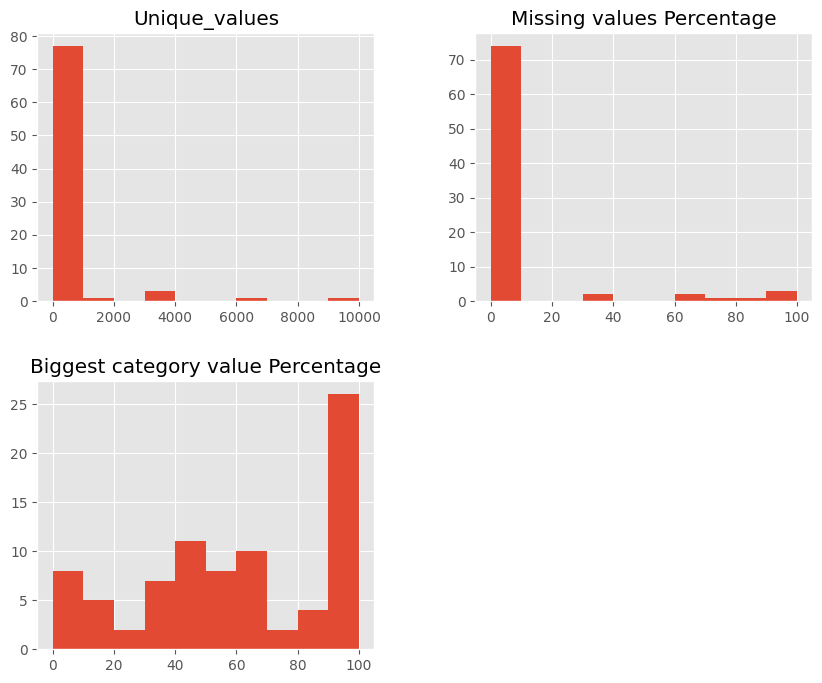

In [17]:
stats_df.hist(figsize = (10, 8));

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>


Lot of interesting things can be observed here:
* `PuaMode` and `Census_ProcessorClass` have 99%+ missing values,  which means that these columns are probably not helpful. So let's drop it for now;
* In `DefaultBrowsersIdentifier` column 95% values belong to one category, this columns is probably also not helpful;
* There are 26 columns in total in which one category contains 90% values. These imbalanced columns may optionally be removed from the dataset;
* Few columns like `Census_IsWIMBootEnabled` don't have any variance. These columns can to dropped.
* One more important point is that there are many columns which are considered to be numerical, but probably they are categorical - like `CityIdentifier`. Let's see more in further steps;


## 5. Data Preprocessing for EDA

The goal of this section is to:
- Drop columns based on the inferences from previous section
- Define the data type for categorical columns

In [18]:
# Initial Shape
train.shape

(10000, 83)

In [19]:
# Drop the columns which have more than 90% values missing
good_cols = list(train.columns)
for col in train.columns:
    missing_share = train[col].isnull().sum()/train.shape[0]
    if missing_share > 0.9:
        good_cols.remove(col)
        print("Removed: ", col)

Removed:  DefaultBrowsersIdentifier
Removed:  PuaMode
Removed:  Census_ProcessorClass


Remove the columns where one category contains more than 90% values

In [20]:
# Drop the columns where one category contains more than 90% values
for col in good_cols:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)
        print("Removed: ", col)

Removed:  ProductName
Removed:  IsBeta
Removed:  IsSxsPassiveMode
Removed:  AVProductsEnabled
Removed:  Platform
Removed:  OsVer
Removed:  IsProtected
Removed:  SMode
Removed:  Firewall
Removed:  Census_DeviceFamily
Removed:  Census_HasOpticalDiskDrive
Removed:  Census_OSArchitecture
Removed:  Census_IsPortableOperatingSystem
Removed:  Census_IsFlightsDisabled
Removed:  Census_IsVirtualDevice
Removed:  Census_IsPenCapable


Remove the columns which doesn't having any variance

In [21]:
# Drop the columns which have only one unique value
for col in good_cols:
    unique_value = train[col].nunique()
    if unique_value == 1:
        good_cols.remove(col)
        print("Removed: ", col)

Removed:  AutoSampleOptIn
Removed:  Census_IsFlightingInternal
Removed:  Census_ThresholdOptIn
Removed:  Census_IsWIMBootEnabled


Select only the good columns

In [22]:
# Filter the data for relevant columns only
train = train[good_cols]

In [23]:
# Dimentions of data
train.shape

(10000, 60)

In [24]:
# Export. Make sure 'Data/Intermediate' exists.
#train.to_csv('malware_df_clean.csv')

###  Define the data type for categorical columns
In practice, among the numerical variables, many corresponds to identifiers. In the current dataset, the truly numerical variables are in fact rare. Below, create a list of the variables which are truly numerical, according the data description.

In [25]:
# Numeric columns
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges',
    'AVProductsInstalled'
]

List down binary variables. They can be treated as numericals by tree based algorithms

In [26]:
# Binary columns
binary_columns = [c for c in train.columns if train[c].nunique() == 2]

In [27]:
binary_columns

['HasTpm',
 'UacLuaenable',
 'Census_IsSecureBootEnabled',
 'Census_IsTouchEnabled',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Wdft_IsGamer',
 'HasDetections']

Finally create a list of categorical columns

In [28]:
# Categorical columns
categorical_columns = [c for c in train.columns
                       if (c not in true_numerical_columns) & (c not in binary_columns)]

In [29]:
categorical_columns

['MachineIdentifier',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'RtpStateBitfield',
 'AVProductStatesIdentifier',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Processor',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IeVerIdentifier',
 'SmartScreen',
 'Census_MDC2FormFactor',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTypeName',
 'Census_ChassisTypeName',
 'Census_PowerPlatformRoleName',
 'Census_InternalBatteryType',
 'Census_OSVersion',
 'Census_OSBranch',
 'Census_OSBuildNumber',
 'Census_OSBuildRevision',
 'Census_OSEdition',
 'Census_OSSkuName',
 'Census_OSInstallTypeName',
 'Census_OSInstallLanguageIdentifier',
 'Census_OSUILocaleIdentifier',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_GenuineStateName',
 'Census_ActivationChannel',
 'Census_Fl

In [30]:
import yaml

# create dictionary with column categories
num_dict = {'numerical-columns': true_numerical_columns}
binary_dict = {'binary-columns': binary_columns}
cat_dict = {'categorical-columns': categorical_columns}

with open('schema.yaml', 'a') as file:
    documents = yaml.dump(num_dict, file)
    documents = yaml.dump(binary_dict, file)
    documents = yaml.dump(cat_dict, file)

##  6. Exploratory Data Analysis

The goal of this section is to:
- Check proportion of columns by data type
- Encoding the categorical features
- Check if the target variable is balanced or is there a need to balance the target variable
- Understand the correlation of various features with each other, so that you understand which variables might be giving same information
- Get insights or relationships from the data which may be useful from business perspective
- Perform statistical significance test for categorical features

### Check proportion of columns by data type

In [31]:
%%time
#train = pd.read_csv('Data/Intermediate/malware_df_clean.csv',
 #                   nrows = nrows)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.34 µs


In [32]:
train.head()

MachineIdentifier EngineVersion       AppVersion  \
0  0000028988387b115f69f31a3bf04f09   1.1.15100.1  4.18.1807.18075   
1  000007535c3f730efa9ea0b7ef1bd645   1.1.14600.4     4.13.17134.1   
2  000007905a28d863f6d0d597892cd692   1.1.15100.1  4.18.1807.18075   
3  00000b11598a75ea8ba1beea8459149f   1.1.15100.1  4.18.1807.18075   
4  000014a5f00daa18e76b81417eeb99fc   1.1.15100.1  4.18.1807.18075   

   AvSigVersion  RtpStateBitfield  AVProductStatesIdentifier  \
0  1.273.1735.0               7.0                    53447.0   
1    1.263.48.0               7.0                    53447.0   
2  1.273.1341.0               7.0                    53447.0   
3  1.273.1527.0               7.0                    53447.0   
4  1.273.1379.0               7.0                    53447.0   

   AVProductsInstalled  HasTpm  CountryIdentifier  CityIdentifier  \
0                  1.0       1                 29        128035.0   
1                  1.0       1                 93          1482.0   
2                  1.0       1                 86        153579.0   
3                  1.0       1                 88         20710.0   
4                  1.0       1                 18         37376.0   

   OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  \
0                    18.0                 35                          171   
1                    18.0                119                           64   
2                    18.0                 64                           49   
3                     NaN                117                          115   
4                     NaN                277                           75   

  Processor  OsBuild  OsSuite OsPlatformSubRelease  \
0       x64    17134      256                  rs4   
1       x64    17134      256                  rs4   
2       x64    17134      768                  rs4   
3       x64    17134      256                  rs4   
4       x64    17134      768                  rs4   

                                 OsBuildLab SkuEdition  IeVerIdentifier  \
0  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
1  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
2  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   
3  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
4  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   

    SmartScreen  UacLuaenable Census_MDC2FormFactor  Census_OEMNameIdentifier  \
0           NaN           1.0               Desktop                    2668.0   
1           NaN           1.0              Notebook                    2668.0   
2  RequireAdmin           1.0               Desktop                    4909.0   
3  ExistsNotSet           1.0               Desktop                    1443.0   
4  RequireAdmin           1.0              Notebook                    1443.0   

   Census_OEMModelIdentifier  Census_ProcessorCoreCount  \
0                     9124.0                        4.0   
1                    91656.0                        4.0   
2                   317701.0                        4.0   
3                   275890.0                        4.0   
4                   331929.0                        4.0   

   Census_ProcessorManufacturerIdentifier  Census_ProcessorModelIdentifier  \
0                                     5.0                           2341.0   
1                                     5.0                           2405.0   
2                                     5.0                           1972.0   
3                                     5.0                           2273.0   
4                                     5.0                           2500.0   

   Census_PrimaryDiskTotalCapacity Census_PrimaryDiskTypeName  \
0                         476940.0                        HDD   
1                         476940.0                        HDD   
2                         114473.0                  

In [33]:
# train.drop(0, inplace=True)

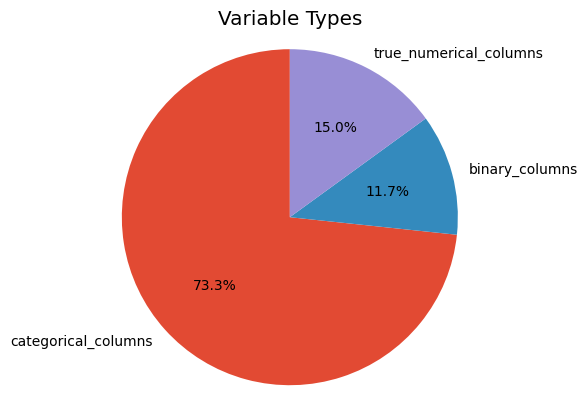

In [34]:
# Plot proportion of columns by data type using a pie chart
variables = {
    'categorical_columns': len(categorical_columns),
    'binary_columns': len(binary_columns),
    'true_numerical_columns': len(true_numerical_columns)
}

# Create a pie chart
labels = variables.keys()
sizes = variables.values()

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Set the title
plt.title('Variable Types')

# Display the chart
plt.show()

**Inferences:**

Most of the current variables are categories. Depending on the cardinality of each variable, we will treat the columns differently. This we will see how to do in detail in the upcoming feature engineering step.

### Compute cardinality of categorical columns

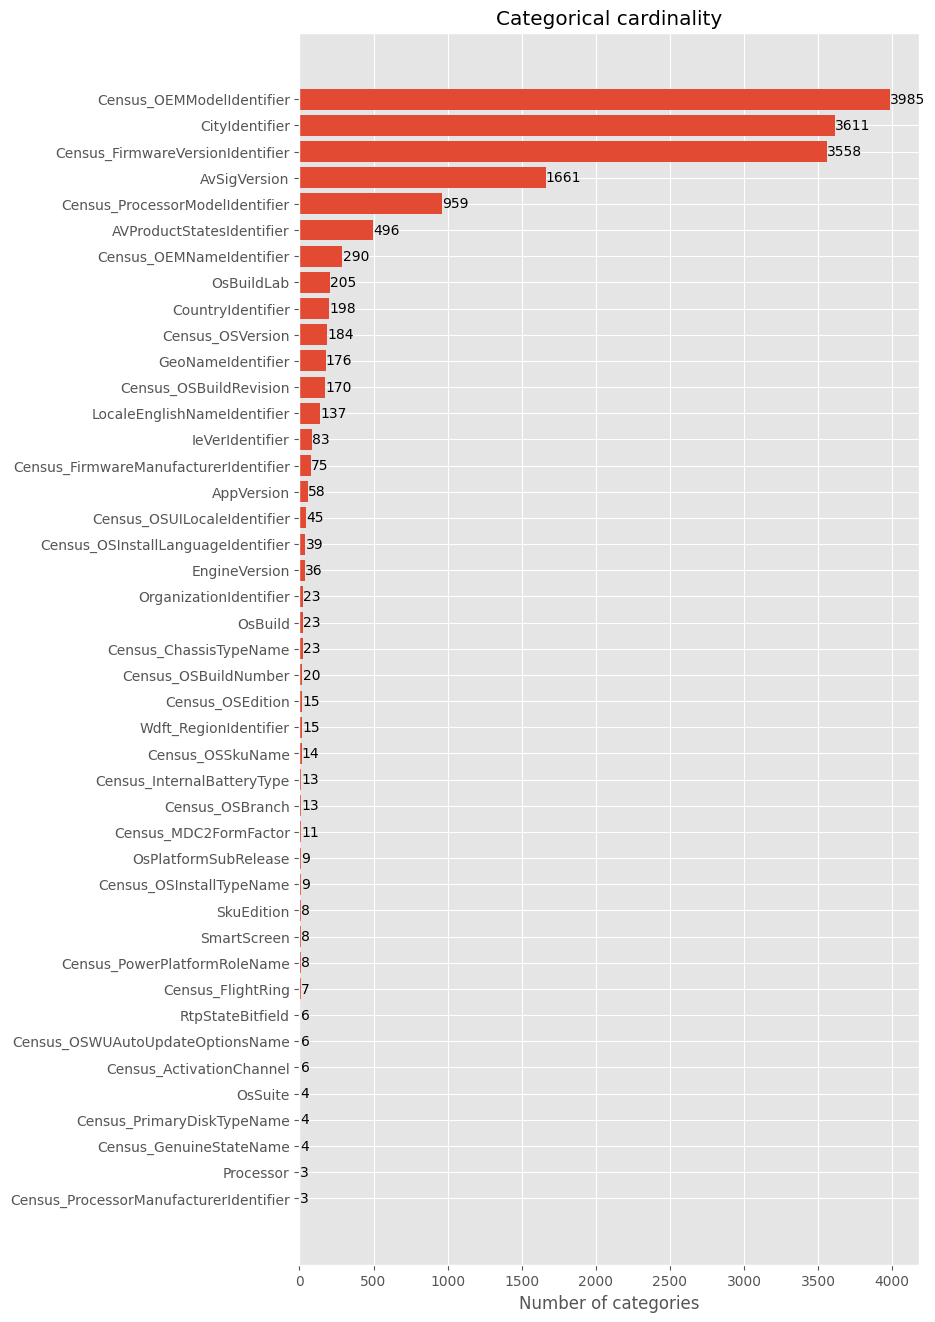

In [35]:
# PLot cardinality
cardinality = []
for c in categorical_columns:
    if c == 'MachineIdentifier': continue
    cardinality.append([c, train[c].nunique()])

# Sort
cardinality.sort(key = lambda x:x[1], reverse=True)

# Plot
# Extract labels and values
labels, values = zip(*cardinality)

# Create a horizontal bar plot
plt.figure(figsize=(8, 16))
bars = plt.barh(labels, values)
plt.xlabel('Number of categories')
plt.title('Categorical cardinality')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest cardinality at the top

# Add number annotations to the bars
for bar, value in zip(bars, values):
    plt.text(value + 2, bar.get_y() + bar.get_height()/2, str(value), ha='left', va='center')

plt.show()

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

Top few variables having more than 20-30 categories. They seem to be identifiers (eg: city identifier). So let's remove the top few variables, then plot it.

High cardinality:  EngineVersion
High cardinality:  AppVersion
High cardinality:  AvSigVersion
High cardinality:  AVProductStatesIdentifier
High cardinality:  CountryIdentifier
High cardinality:  CityIdentifier
High cardinality:  GeoNameIdentifier
High cardinality:  LocaleEnglishNameIdentifier
High cardinality:  OsBuildLab
High cardinality:  IeVerIdentifier
High cardinality:  Census_OEMNameIdentifier
High cardinality:  Census_OEMModelIdentifier
High cardinality:  Census_ProcessorModelIdentifier
High cardinality:  Census_OSVersion
High cardinality:  Census_OSBuildRevision
High cardinality:  Census_OSInstallLanguageIdentifier
High cardinality:  Census_OSUILocaleIdentifier
High cardinality:  Census_FirmwareManufacturerIdentifier
High cardinality:  Census_FirmwareVersionIdentifier


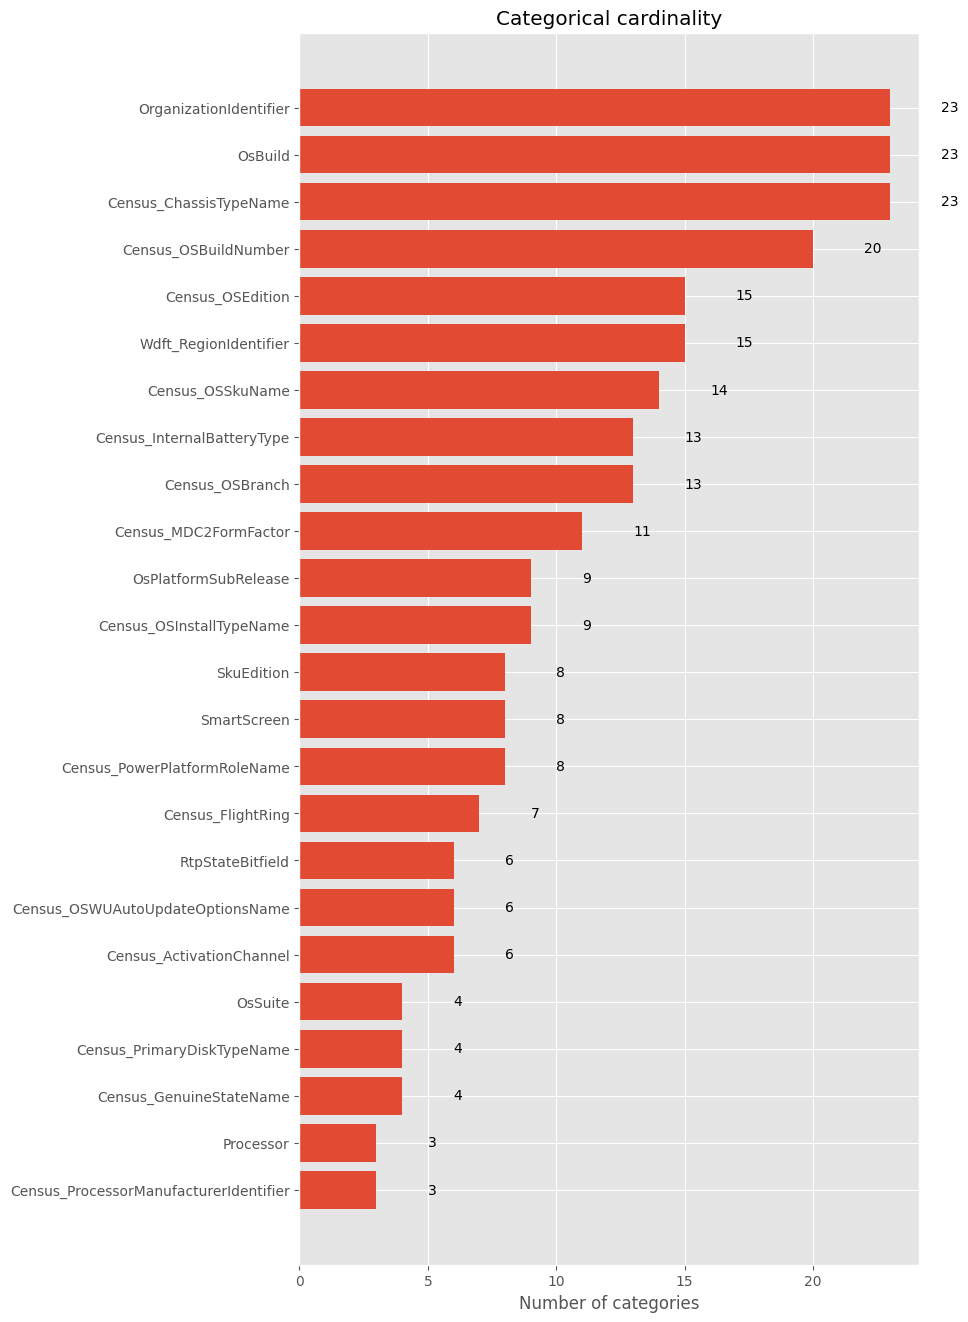

In [36]:
# Plot Cardinality
cardinality = []
for c in categorical_columns:
    if c == 'MachineIdentifier': continue
    if train[c].nunique() >= 30:
        print("High cardinality: ", c)
        continue
    cardinality.append([c, train[c].nunique()])


# Sort
cardinality.sort(key = lambda x:x[1], reverse=True)


# Plot
# Extract labels and values
labels, values = zip(*cardinality)

# Create a horizontal bar plot
plt.figure(figsize=(8, 16))
bars = plt.barh(labels, values)
plt.xlabel('Number of categories')
plt.title('Categorical cardinality')
plt.gca().invert_yaxis()  # Invert the y-axis to display the highest cardinality at the top

# Add number annotations to the bars
for bar, value in zip(bars, values):
    plt.text(value + 2, bar.get_y() + bar.get_height()/2, str(value), ha='left', va='center')

plt.show()

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

25 variables have high cardinality (more than 30 unique values). During feature engineering, we will treat them differently.


### Check distribution of target variable

In [37]:
# Get count of target class
train['HasDetections'].value_counts()

1    5050
0    4950
Name: HasDetections, dtype: int64

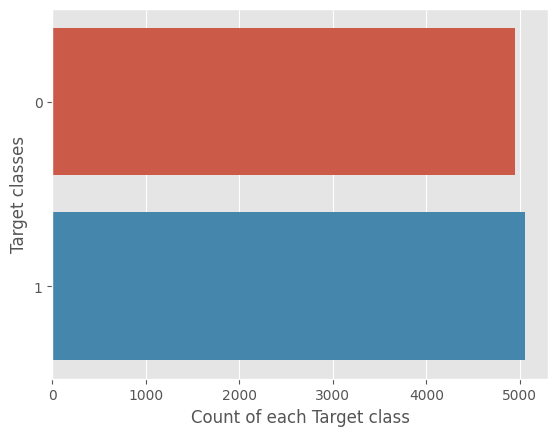

In [38]:
# Draw a countplot to check the distribution of target variable
sns.countplot(y=train['HasDetections'] ,data=train)
plt.xlabel("Count of each Target class")
plt.ylabel("Target classes")
plt.show()

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

The target variable is **balanced**, which is nice.

### Check Correlations (Caution!)

You can plot a correlation matrix to check correlation between variables. Each cell in the matrix shows the correlation between two variables.

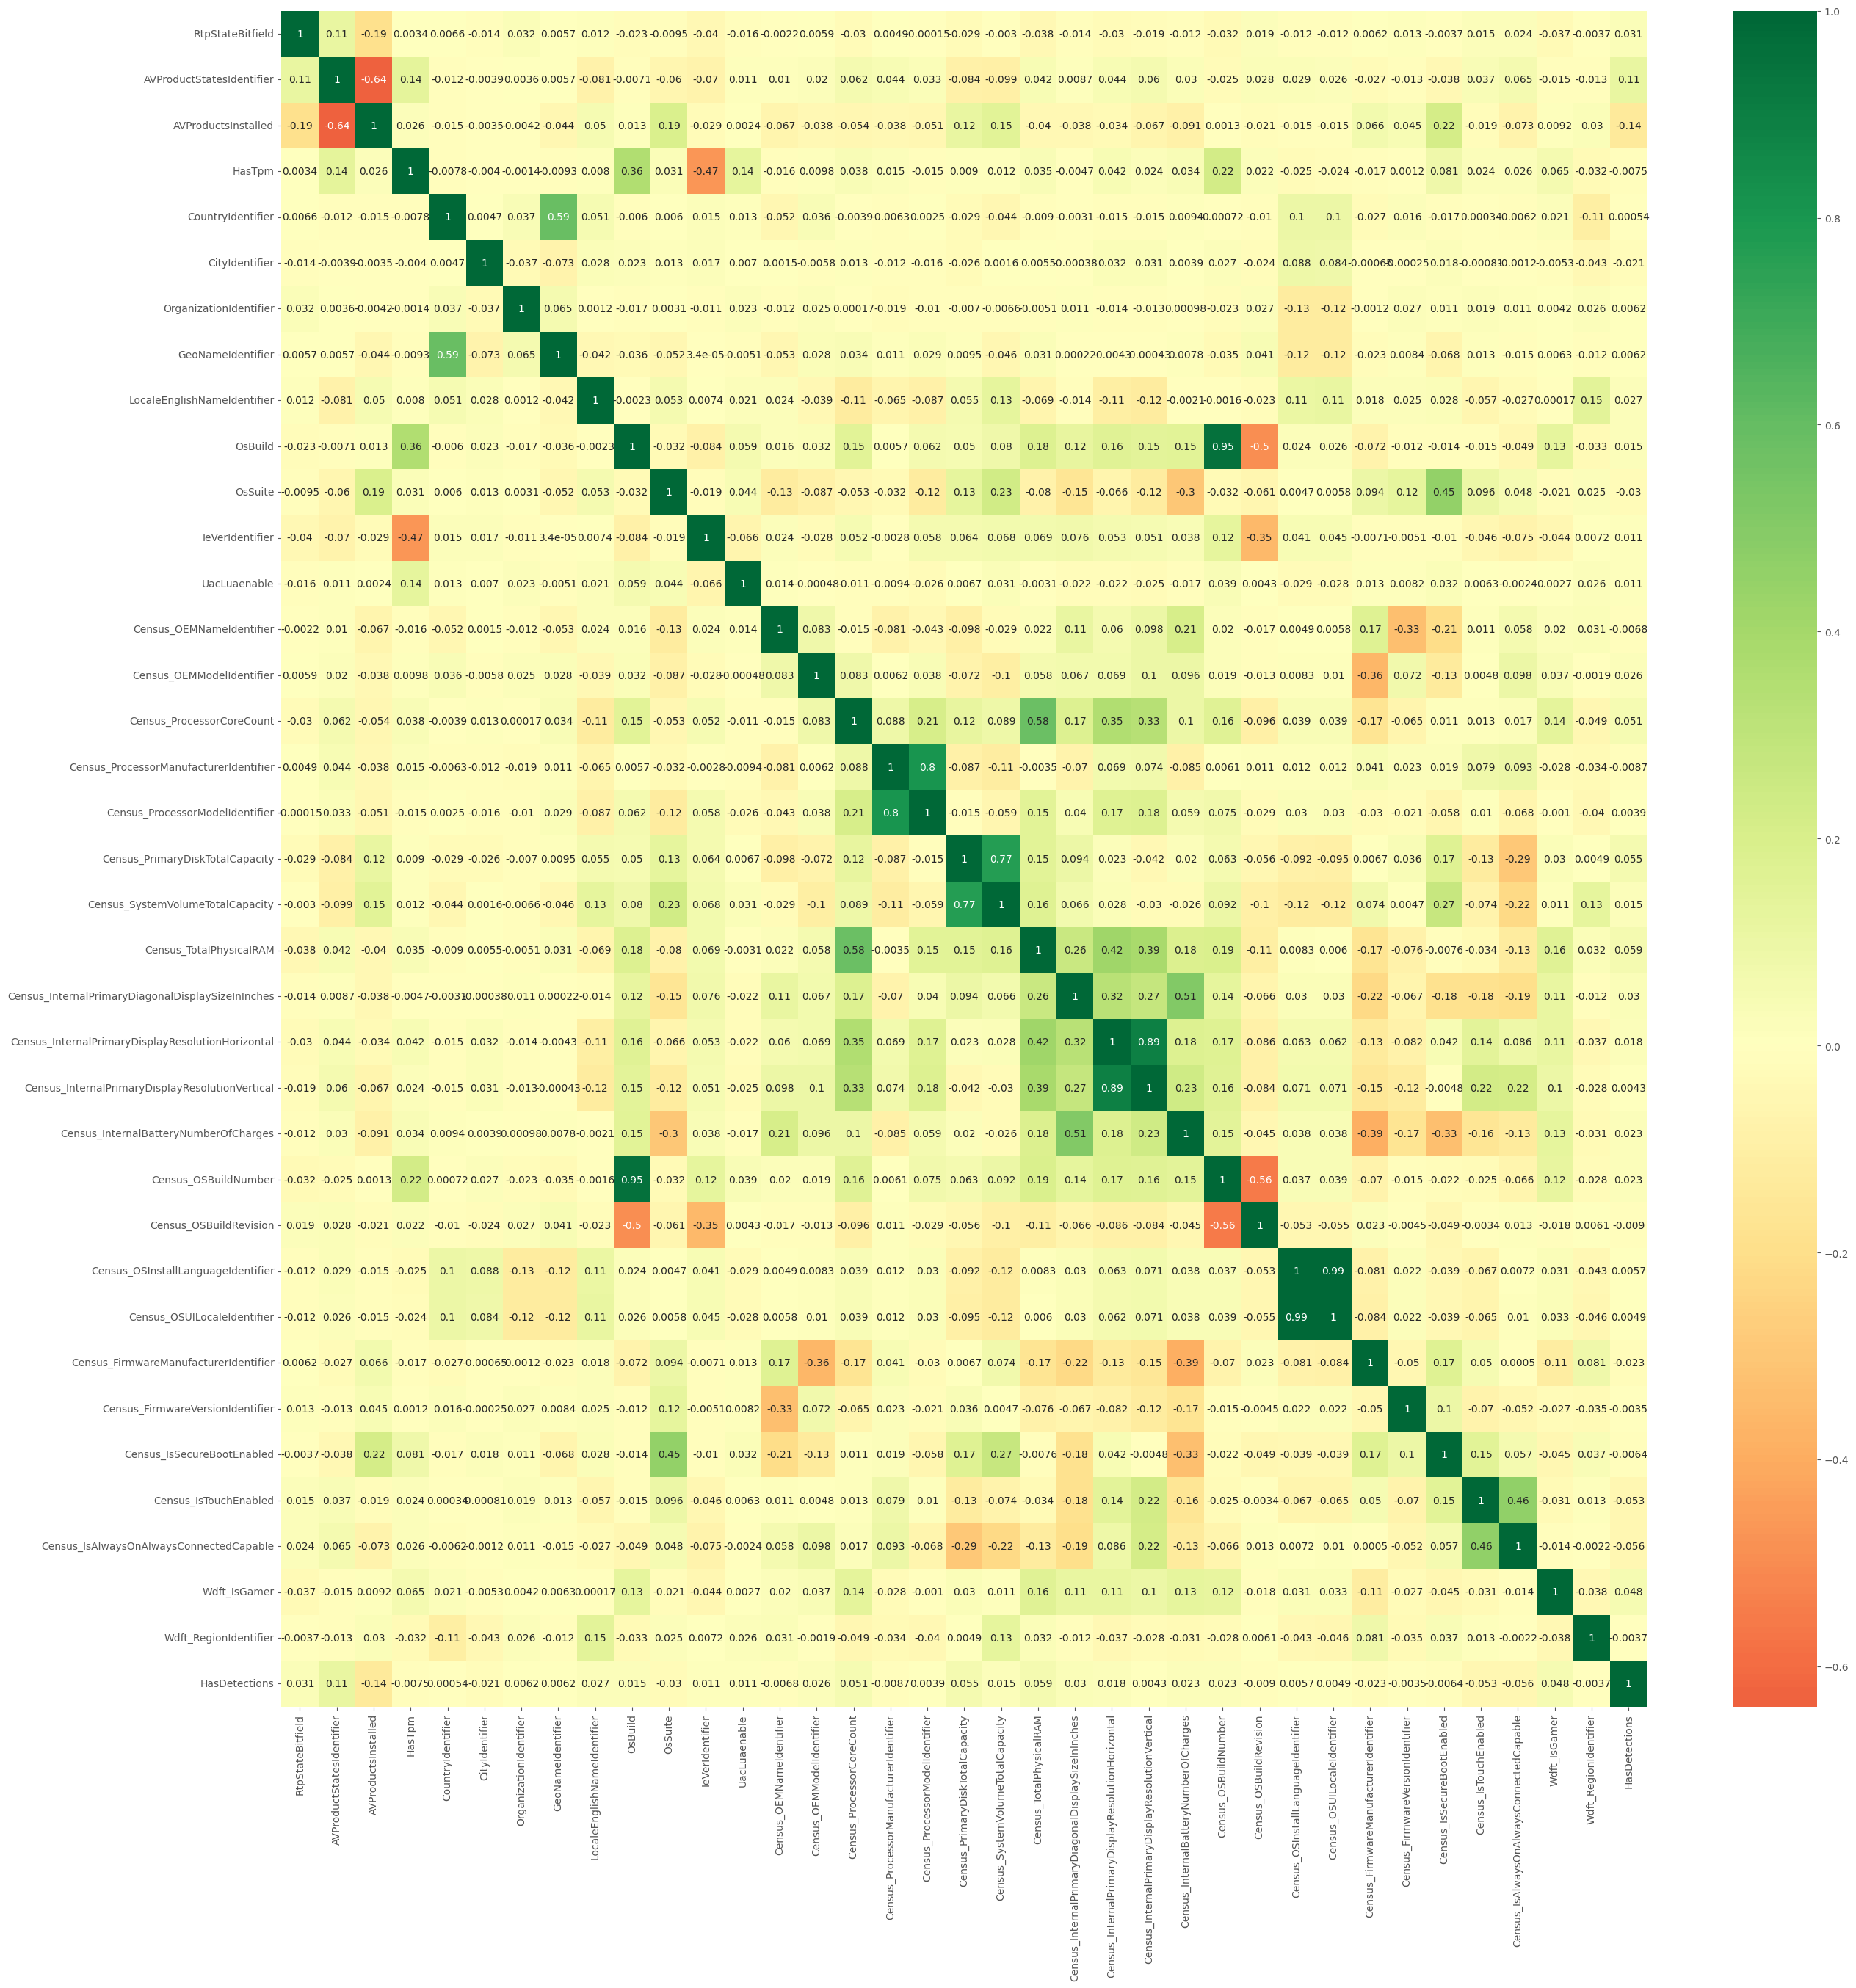

In [39]:
# Let's check the correlations between all variables
plt.figure(figsize=(30,30))
p=sns.heatmap(train.corr(), annot=True,cmap='RdYlGn',center=0)

It's time to deep dive in some of the most important variables and understand their relationship with target variable

##  7. Understand Detection Rates by each Feature

Let's understand few functions first, which would be used in further analysis

In [40]:
def plot_detection_count(col, top_n = 8):
    top_cat               = list(train[col].value_counts(dropna=True).index[:top_n])
    top_cat_df            = train.loc[train[col].isin(top_cat)]
    # Create a bar chart using Seaborn with the 'hue' parameter and custom labels in the legend
    plt.figure(figsize=(10, 6))
    sns.countplot(data=top_cat_df, x=col, hue='HasDetections', hue_order=[1, 0],
                palette="Set1")
    # Set labels and title
    plt.xlabel(col)
    plt.ylabel('Counts')
    plt.title(f'Bar Chart of {col}')
    # Create a custom legend
    labels = ['Has Detection', 'No Detection']
    plt.legend(labels)
    plt.show()

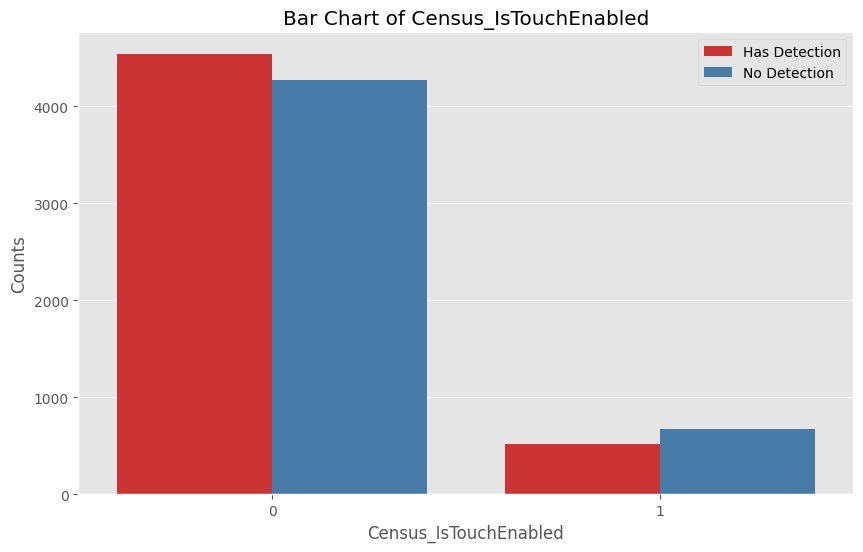

In [41]:
plot_detection_count('Census_IsTouchEnabled')

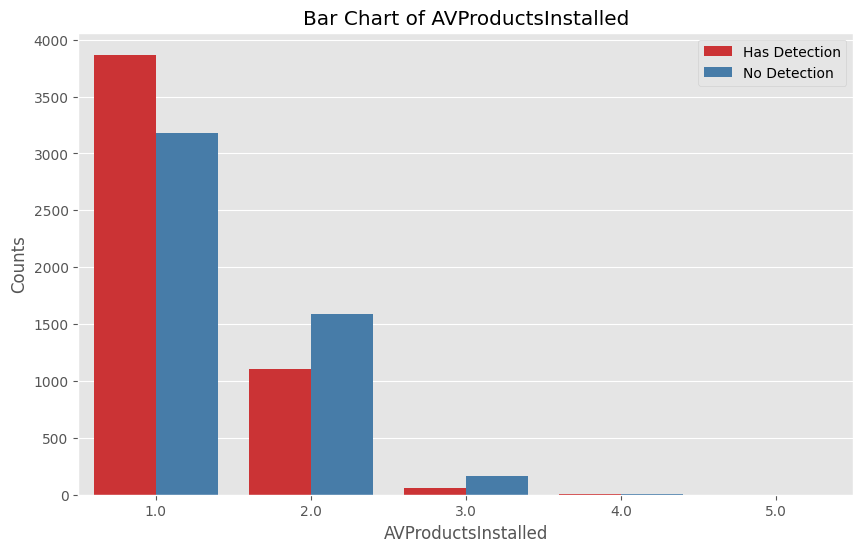

In [42]:
plot_detection_count('AVProductsInstalled')

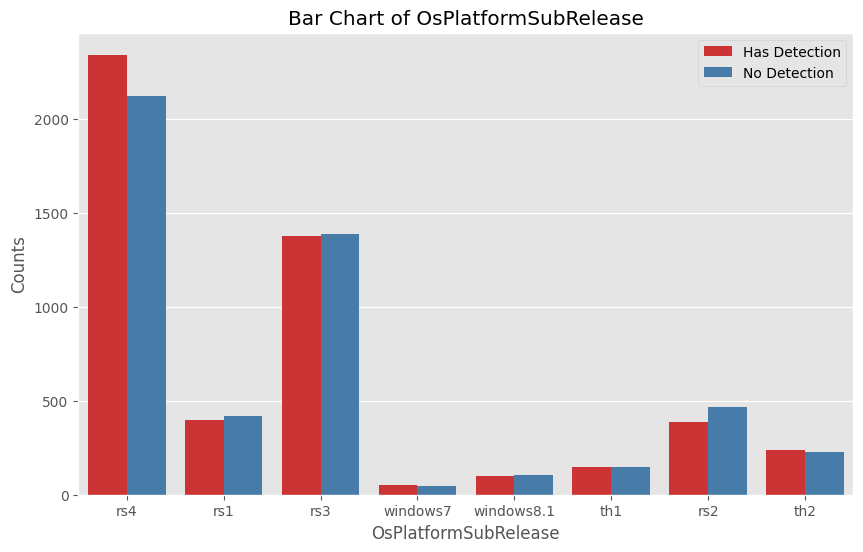

In [43]:
plot_detection_count('OsPlatformSubRelease')

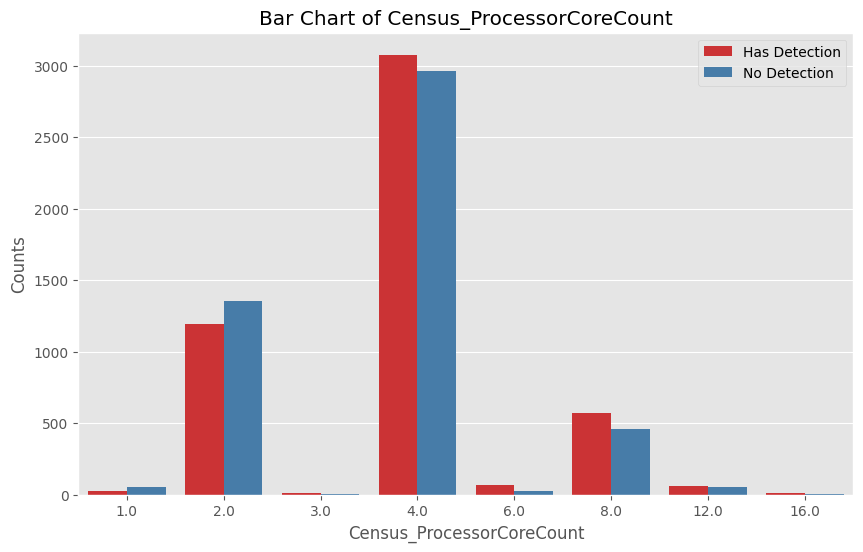

In [44]:
plot_detection_count('Census_ProcessorCoreCount')

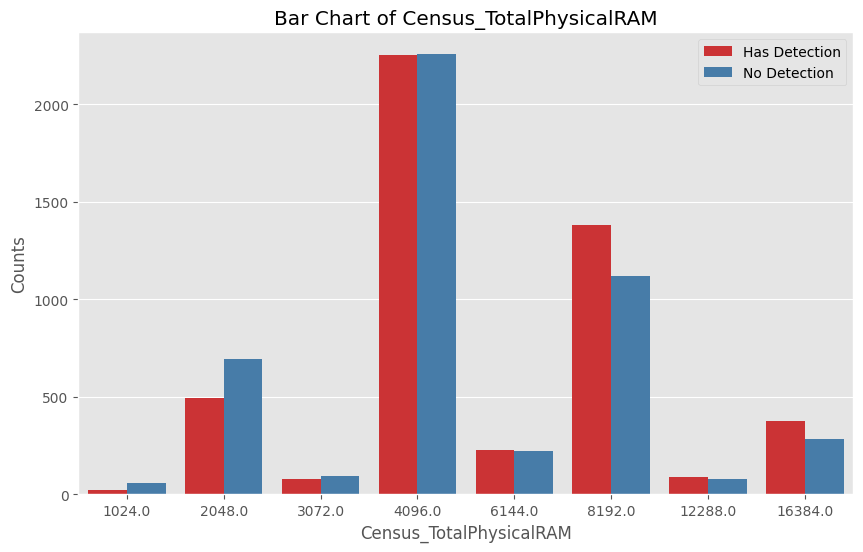

In [45]:
plot_detection_count('Census_TotalPhysicalRAM')

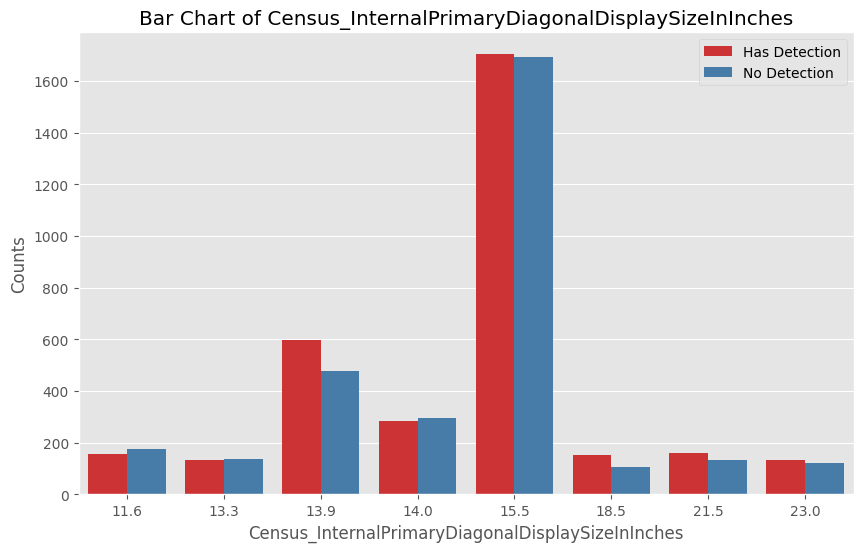

In [46]:
plot_detection_count('Census_InternalPrimaryDiagonalDisplaySizeInInches')

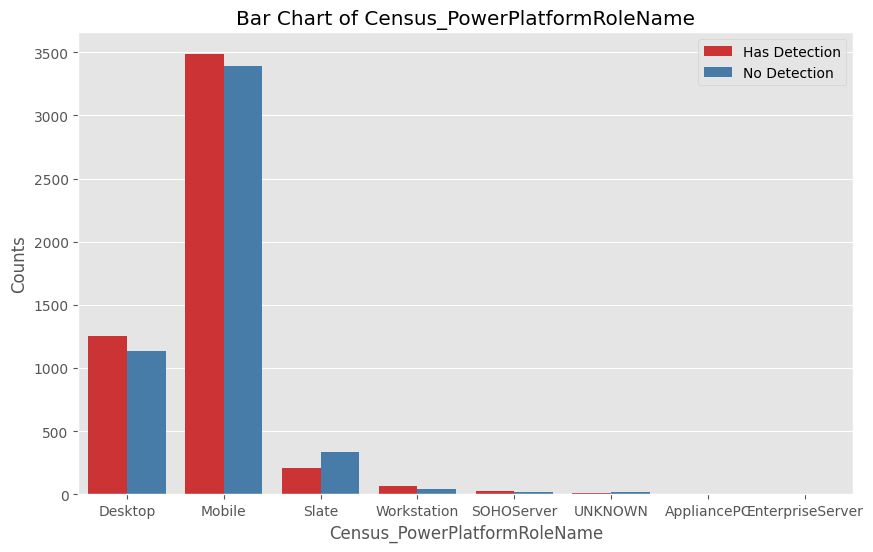

In [47]:
plot_detection_count('Census_PowerPlatformRoleName')

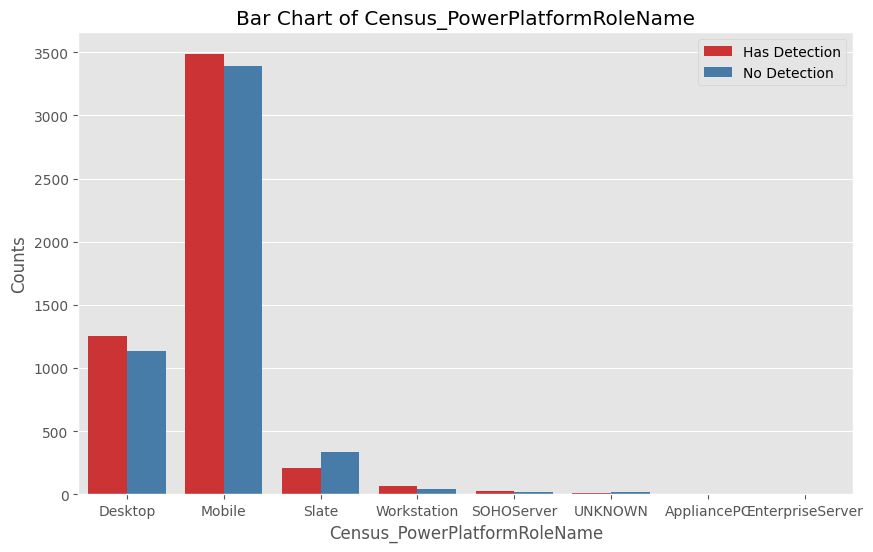

In [48]:
plot_detection_count('Census_PowerPlatformRoleName')

### Detection Rate Plot

Rather than building different functions, let's create a single function which can be used for EDA for individual variables

In [49]:
# Detection rate = Count of machines with malware / Total machines

def plot_detection_rate(col_1, col_2, top_n=6):
    top_cat               = list(train[col_2].value_counts(dropna=True).index[:top_n])
    print(f"{col_2} has {train[col_2].nunique()} unique values and type: {train[col_2].dtype}.")
    print(train[col_2].value_counts().head())

    top_cat_df            = train.loc[train[col_2].isin(top_cat)]
    top_cat_df = top_cat_df.groupby([col_1, col_2]).agg({'HasDetections': ['count', 'mean']})

    for i in range(train[col_1].nunique()):
        print(i)
        # Create the primary y-axis
        if i == 0:
            device = 'Non-Touch Device'
        elif i == 1:
            device = 'Touch Device'
        else:
            device = 'Device'

        fig, ax1 = plt.subplots()
        ax1.bar(top_cat_df.loc[i].index, top_cat_df.loc[i]['HasDetections']['count'], color = 'g', label=f'{device} counts')
        # Create the secondary y-axis by twinning the current axes
        ax2 = ax1.twinx()
        ax2.plot(top_cat_df.loc[i].index, top_cat_df.loc[i]['HasDetections']['mean'], color = 'r', label=f'Detections rate for {device}')

        # Access and customize the current axes (primary y-axis)
        ax1.set_xlabel(col_2)
        ax1.set_ylabel('Count', color='b')
        ax1.tick_params(axis='y')

        # Access and customize the secondary y-axis
        ax2.set_ylabel('Detections Rate', color='r')
        ax2.tick_params(axis='y')

        # Adding legends
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc='upper right')

        # Title and show the plot
        plt.title(f'Counts of {col_1} by top-{top_n} categories for {device}')
        plt.show()

### Feature: Census_IsTouchEnabled

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- As expected Microsoft has much more computers that touch devices.
- The rate of infections is slightly lower for touch devices.

### Feature: AVProductsInstalled

AVProductsInstalled has 5 unique values and type: float64.
1.0    7048
2.0    2693
3.0     221
4.0       7
5.0       1
Name: AVProductsInstalled, dtype: int64
0


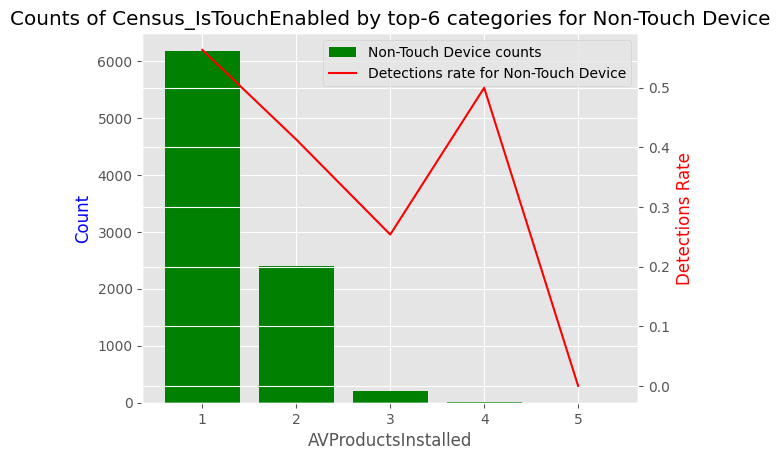

1


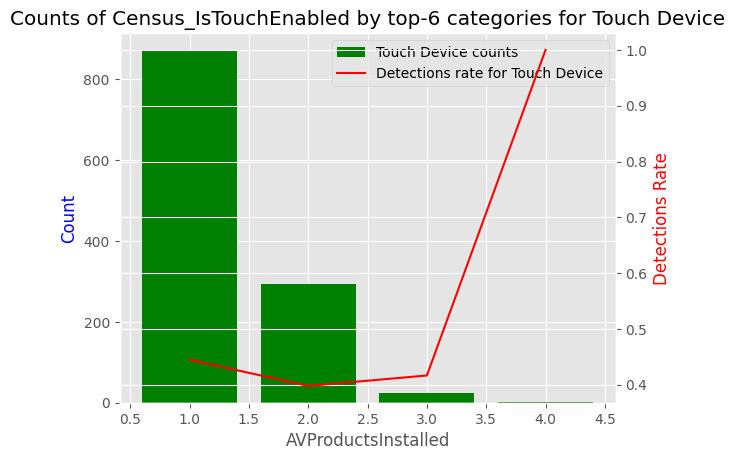

In [50]:
# Only bars
plot_detection_rate('Census_IsTouchEnabled', 'AVProductsInstalled')

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

Hm, interesting.

If a computer has more than one antivirus, it is less likely to be infected. Here the devices which has more than 1 antivirus have less chances of being infected.

In [51]:
train['AVProductsInstalled'].value_counts()

1.0    7048
2.0    2693
3.0     221
4.0       7
5.0       1
Name: AVProductsInstalled, dtype: int64

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- People sometimes install 2 antiviruses, even on touch devices.
- The number of devices with 6 antiviruses is just 1 and that got infected as well. That's why the detection rate is so high. Chances are those AVs were installed by the user after the infection or some sort of malware experiment. Just my guess.

### Feature: OsPlatformSubRelease

OsPlatformSubRelease has 9 unique values and type: object.
rs4    4468
rs3    2766
rs2     856
rs1     818
th2     466
Name: OsPlatformSubRelease, dtype: int64
0


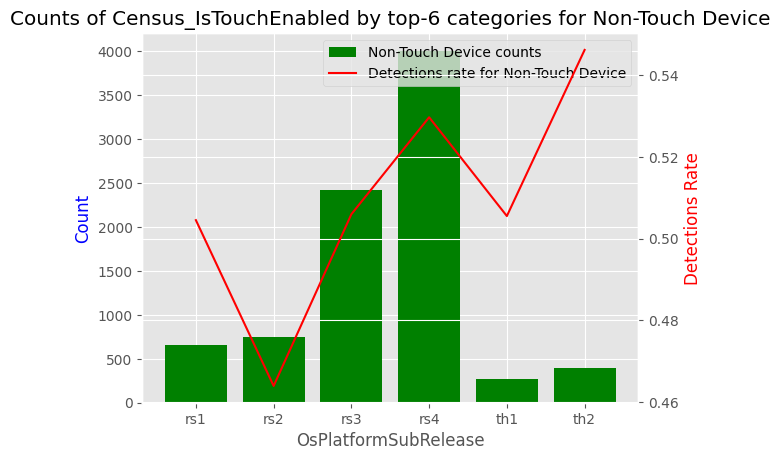

1


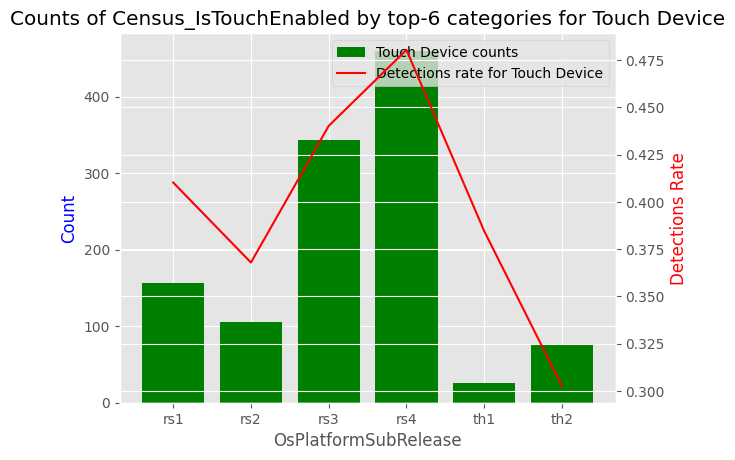

In [52]:
plot_detection_rate('Census_IsTouchEnabled', 'OsPlatformSubRelease')

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- Most computers have Windows 10 (rs*). I suppose Microsoft specifically chose them, so that analysis is focussed on modern devices?

- The detection rate has increased for later 'rs' subreleases.

### Feature: Census_ProcessorCoreCount

Census_ProcessorCoreCount has 10 unique values and type: float64.
4.0     6039
2.0     2552
8.0     1033
12.0     116
6.0       94
Name: Census_ProcessorCoreCount, dtype: int64
0


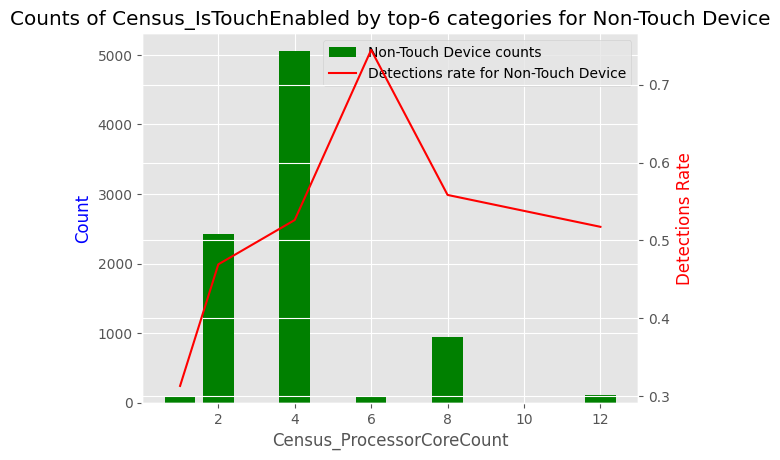

1


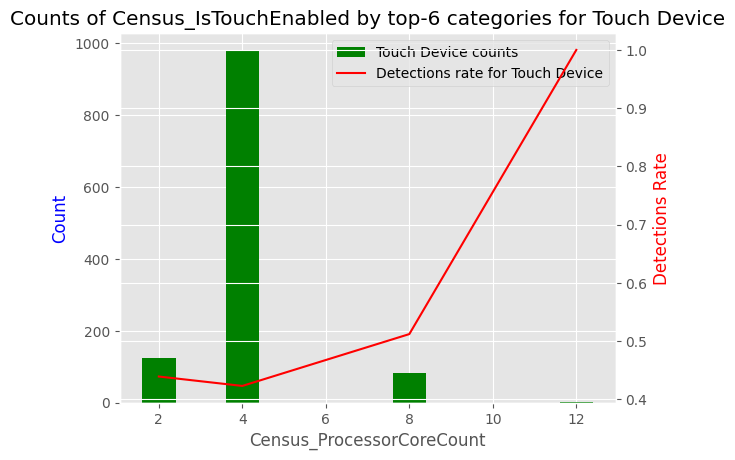

In [53]:
plot_detection_rate('Census_IsTouchEnabled', 'Census_ProcessorCoreCount')

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- Most computers have 2, 4 or 8 cores. For touch devices 4 cores are much more common than other configurations. And these 3 variants cover 95% of devices

- The detection rate (across different processor corecounts) appear to be __fairly uniform for touch devices.__

- The detection rate seems to __improve (decrease) with processor count for non-touch devices.__

### Feature: Census_TotalPhysicalRAM

Census_TotalPhysicalRAM has 50 unique values and type: float64.
4096.0     4509
8192.0     2501
2048.0     1188
16384.0     659
6144.0      452
Name: Census_TotalPhysicalRAM, dtype: int64
0


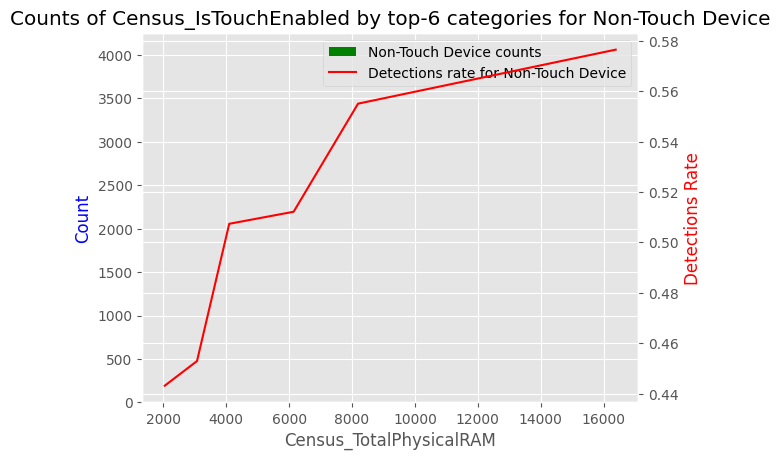

1


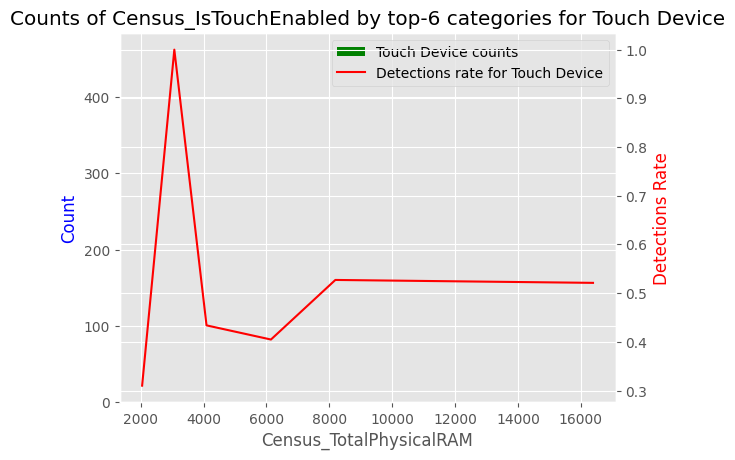

In [54]:
plot_detection_rate('Census_IsTouchEnabled', 'Census_TotalPhysicalRAM')

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- With bigger RAM size the detection rate also seem to increase till a certain point.
- Most computers have <=8 Gb RAM. Quite interesting.

### Feature: Census_InternalPrimaryDiagonalDisplaySizeInInches

Census_InternalPrimaryDiagonalDisplaySizeInInches has 192 unique values and type: float64.
15.5    3396
13.9    1078
14.0     580
11.6     332
21.5     293
Name: Census_InternalPrimaryDiagonalDisplaySizeInInches, dtype: int64
0


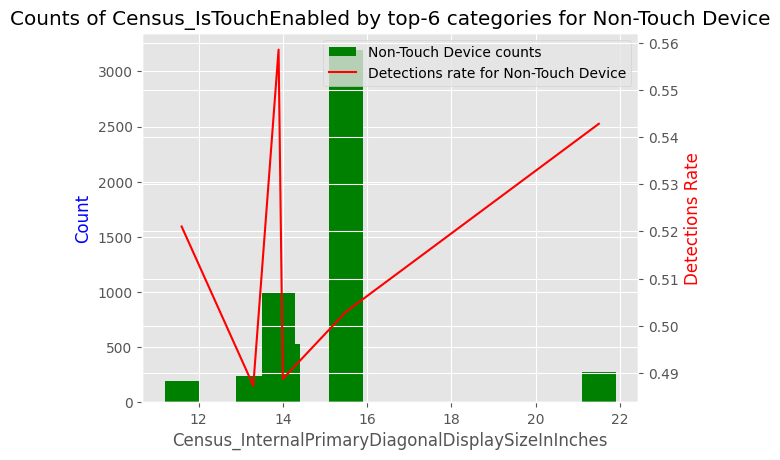

1


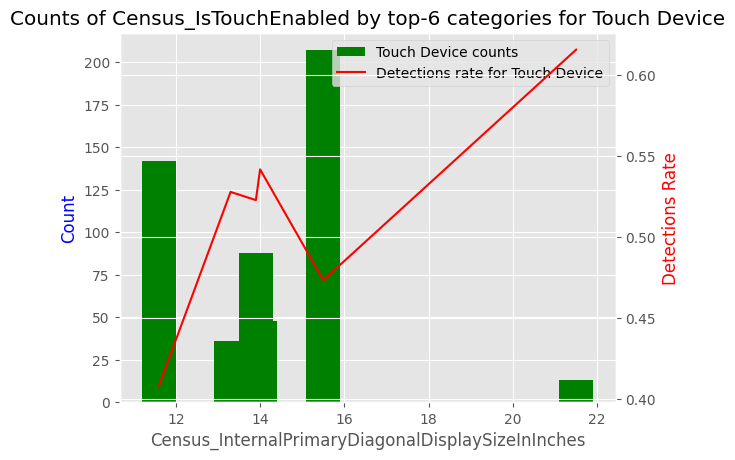

In [55]:
plot_detection_rate('Census_IsTouchEnabled', 'Census_InternalPrimaryDiagonalDisplaySizeInInches')

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- Surprising that most computers have 15.5 inch screens.
- There seem to be an increasing pattern in detection rate for non-touch devices.

### Feature: Census_PowerPlatformRoleName

In [56]:
train['Census_PowerPlatformRoleName'].value_counts(dropna=False, normalize=True).cumsum()

Mobile              0.6873
Desktop             0.9262
Slate               0.9803
Workstation         0.9911
SOHOServer          0.9954
UNKNOWN             0.9984
AppliancePC         0.9992
EnterpriseServer    1.0000
Name: Census_PowerPlatformRoleName, dtype: float64

Census_PowerPlatformRoleName has 8 unique values and type: object.
Mobile         6873
Desktop        2389
Slate           541
Workstation     108
SOHOServer       43
Name: Census_PowerPlatformRoleName, dtype: int64
0


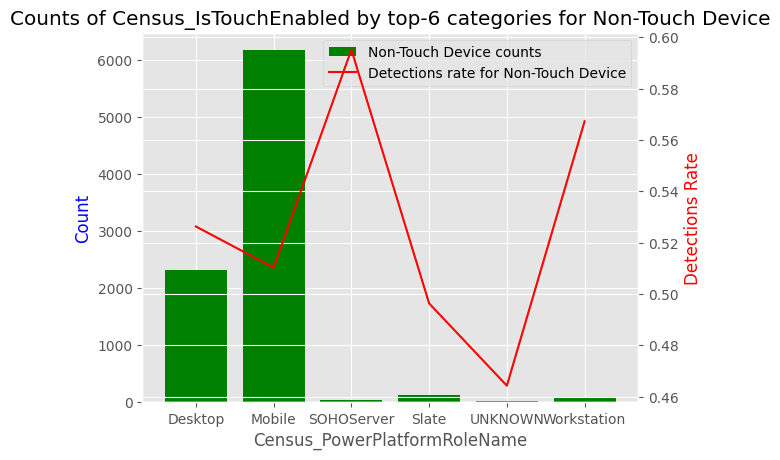

1


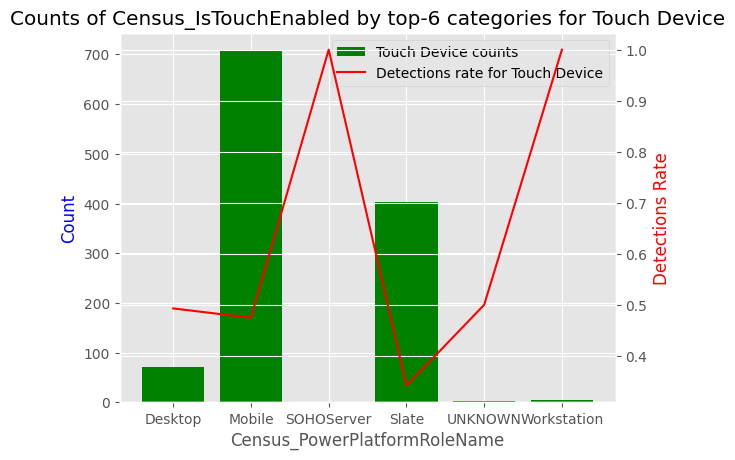

In [57]:
plot_detection_rate('Census_IsTouchEnabled', 'Census_PowerPlatformRoleName')

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

For some reason slates have quite a low rate of detections. Maybe no hackers are interested in them? :)

**I have analysed few of the most important variables individually. It's a good idea to get some practice with other variables as well for further analysis.**

## Analyze numerical columns (grouped by target class)

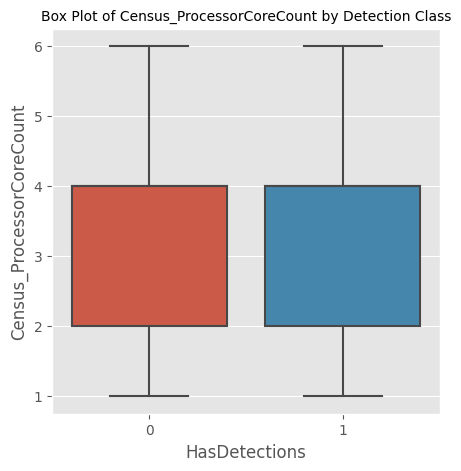

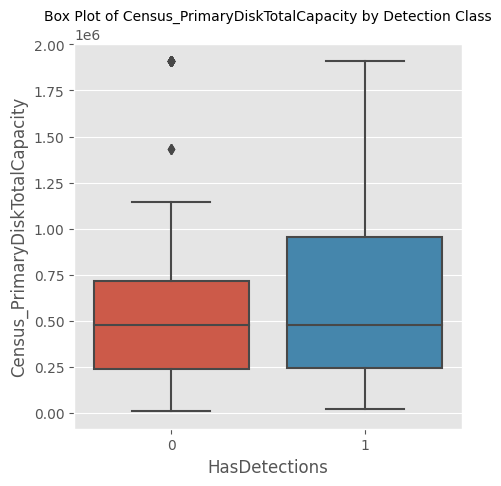

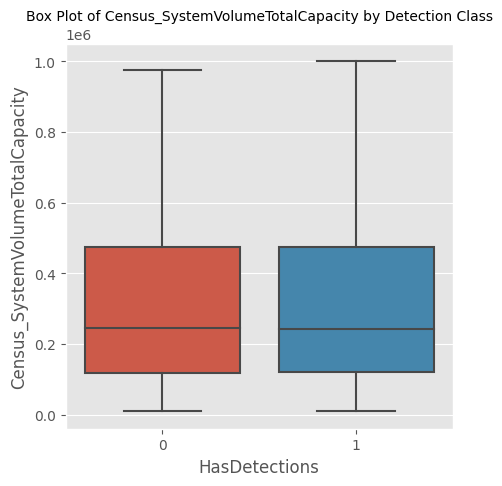

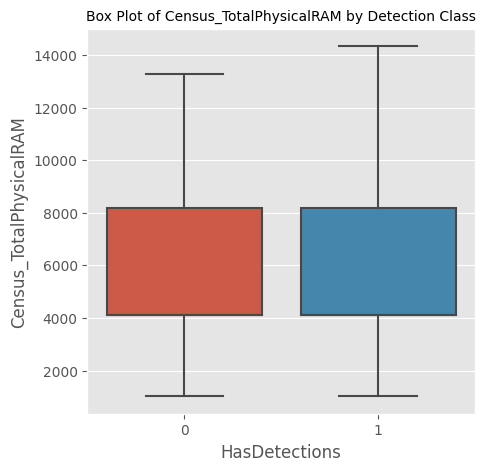

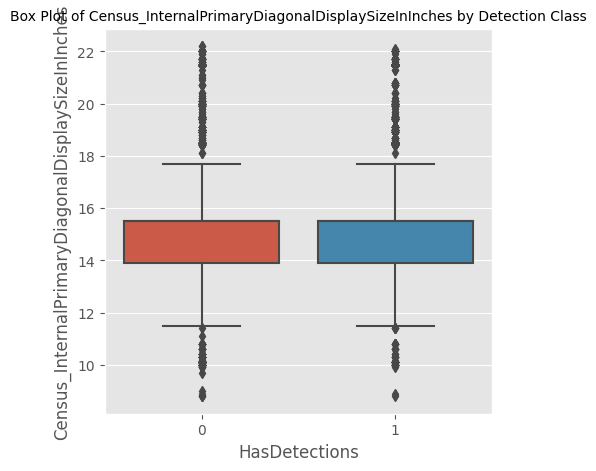

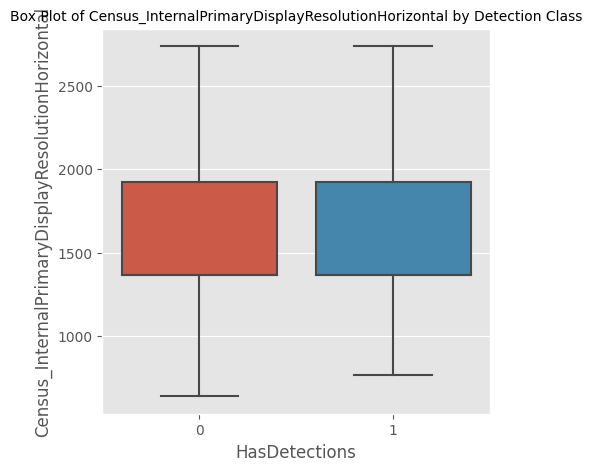

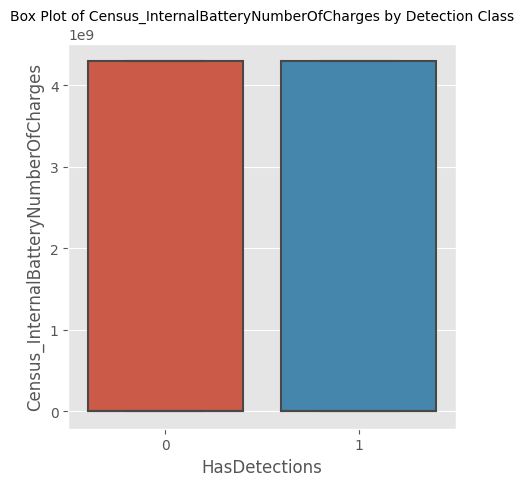

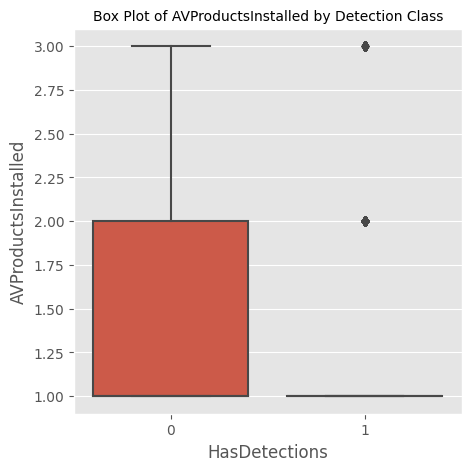

In [58]:
for cols in true_numerical_columns:

    # Remove outliers
    Q1 = train[[cols]].quantile(0.25)
    Q3 = train[[cols]].quantile(0.75)
    IQR = Q3 - Q1

    df = train[~((train[[cols]] < (Q1 - 1.5 * IQR)) |(train[[cols]] > (Q3 + 1.5 * IQR))).any(axis=1)]

    # Draw Plot
    plt.figure(figsize=(5,5), dpi= 100)
    sns.boxplot(x='HasDetections', y=cols, data=df, notch=False)
    plt.title('Box Plot of ' + cols +  ' by Detection Class', fontsize=10)
    plt.show()

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> Inferences:</h3>
</div>

- In case of `AVProductsInstalled`, it can be clearly seen that higher number of antivirus, lesser the chances of being infected.

- For PrimaryDiskTotalCapacity, there is an indication of high capacity implying higher detection rate.

## 8. Statistical Significance Test


### Chi sqare test for categorical columns

Understand whether a given categorical feature has a statistical significant relationship with the Y (`HasDetections`)

In [59]:
from scipy.stats import chi2_contingency

In [60]:
# significance value
alpha = 0.05

significant_categorical_variables = []
for col in categorical_columns[1:] + binary_columns:
    temp = pd.crosstab(train[col],train['HasDetections'].astype('category'))

    # Chi-square stat , p-value, degrees of freedom, expected frequencies
    stat, p, dof, expected = chi2_contingency(temp)
    print(col.ljust(40), ',  chisquared=%.5f,   p-value=%.5f' % (stat, p))

    # Determine whether to reject or keep your null hypothesis
    if p <= alpha:
        significant_categorical_variables.append(col)

EngineVersion                            ,  chisquared=188.53522,   p-value=0.00000
AppVersion                               ,  chisquared=187.36275,   p-value=0.00000
AvSigVersion                             ,  chisquared=1765.52779,   p-value=0.03550
RtpStateBitfield                         ,  chisquared=22.35457,   p-value=0.00045
AVProductStatesIdentifier                ,  chisquared=810.90216,   p-value=0.00000
CountryIdentifier                        ,  chisquared=316.10718,   p-value=0.00000
CityIdentifier                           ,  chisquared=3725.72831,   p-value=0.08763
OrganizationIdentifier                   ,  chisquared=23.11567,   p-value=0.39522
GeoNameIdentifier                        ,  chisquared=219.03713,   p-value=0.01334
LocaleEnglishNameIdentifier              ,  chisquared=179.25958,   p-value=0.00762
Processor                                ,  chisquared=38.99166,   p-value=0.00000
OsBuild                                  ,  chisquared=32.73917,   p-value=0.

In [61]:
# See Significant variables
print(significant_categorical_variables)

['EngineVersion', 'AppVersion', 'AvSigVersion', 'RtpStateBitfield', 'AVProductStatesIdentifier', 'CountryIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Processor', 'OsSuite', 'OsPlatformSubRelease', 'OsBuildLab', 'SmartScreen', 'Census_MDC2FormFactor', 'Census_ProcessorModelIdentifier', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName', 'Census_OSBranch', 'Census_OSBuildNumber', 'Census_OSBuildRevision', 'Census_OSEdition', 'Census_OSSkuName', 'Census_OSInstallTypeName', 'Census_OSInstallLanguageIdentifier', 'Census_OSUILocaleIdentifier', 'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName', 'Census_ActivationChannel', 'Census_FirmwareManufacturerIdentifier', 'Wdft_RegionIdentifier', 'Census_IsTouchEnabled', 'Census_IsAlwaysOnAlwaysConnectedCapable', 'Wdft_IsGamer', 'HasDetections']


#### View cross tabulation and calc odds

In [62]:
ctab = pd.crosstab(train['Processor'],train['HasDetections'].astype('category'))
ctab

HasDetections     0     1
Processor                
arm64             2     0
x64            4414  4681
x86             534   369

#### Odds

In [63]:
# Calc odds
ctab.columns = ctab.columns.add_categories('odds')
ctab['odds'] = ctab[1] / ctab[0]
ctab

HasDetections     0     1      odds
Processor                          
arm64             2     0  0.000000
x64            4414  4681  1.060489
x86             534   369  0.691011

#### Odds Ratio

In [64]:
# Calc odds ratio = Odds / (sum of all 1's / sum of all 0's)
ctab.columns = ctab.columns.add_categories('odds_ratio')
ctab['odds_ratio'] = ctab['odds'] / (ctab[1].sum()/ctab[0].sum())
ctab

HasDetections     0     1      odds  odds_ratio
Processor                                      
arm64             2     0  0.000000    0.000000
x64            4414  4681  1.060489    1.039490
x86             534   369  0.691011    0.677328

##  ANOVA test

#### ANOVA with scipy.stats api

In [65]:
# significance value
alpha = 0.05

significant_numerical_variables = []
for col in true_numerical_columns:
    # Get F and p value
    F, p = f_oneway(train[train.HasDetections == 1][col].dropna(),
                    train[train.HasDetections == 0][col].dropna())

    # Determine whether to reject or keep null hypothesis
    print(col.ljust(50), ',   F-statistic=%.5f, p=%.5f' % (F, p))
    if p <= alpha:
        significant_numerical_variables.append(col)

Census_ProcessorCoreCount                          ,   F-statistic=25.89023, p=0.00000
Census_PrimaryDiskTotalCapacity                    ,   F-statistic=29.68112, p=0.00000
Census_SystemVolumeTotalCapacity                   ,   F-statistic=2.12956, p=0.14451
Census_TotalPhysicalRAM                            ,   F-statistic=34.77631, p=0.00000
Census_InternalPrimaryDiagonalDisplaySizeInInches  ,   F-statistic=8.95413, p=0.00278
Census_InternalPrimaryDisplayResolutionHorizontal  ,   F-statistic=3.17021, p=0.07502
Census_InternalPrimaryDisplayResolutionVertical    ,   F-statistic=0.17993, p=0.67145
Census_InternalBatteryNumberOfCharges              ,   F-statistic=5.28992, p=0.02147
AVProductsInstalled                                ,   F-statistic=196.29554, p=0.00000


In [66]:
out = f_oneway(train[train.HasDetections == 1][col].dropna(),
                    train[train.HasDetections == 0][col].dropna())

out

F_onewayResult(statistic=196.29553695799504, pvalue=3.5217472516662344e-44)

In [67]:
# See Significant variables
print(significant_numerical_variables)

['Census_ProcessorCoreCount', 'Census_PrimaryDiskTotalCapacity', 'Census_TotalPhysicalRAM', 'Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_InternalBatteryNumberOfCharges', 'AVProductsInstalled']


#### ANOVA with statsmodels api

In [68]:
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

Fit ANOVA model

In [69]:
model = ols('Census_ProcessorCoreCount ~ C(HasDetections)', train).fit()
print(f"Overall model F({model.df_model: .0f}, {model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")

# ANOVA table
res = sm.stats.anova_lm(model, typ=2)
res

Overall model F( 1,  9954) =  25.890, p =  0.0000


sum_sq      df          F        PR(>F)
C(HasDetections)    104.558813     1.0  25.890229  3.679893e-07
Residual          40199.660954  9954.0        NaN           NaN

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> EDA Inferences:</h3>
</div>

- The target class in balanced
- More than 85% columns are either categorical or binary, only 14.6% columns are numerical
- There are few columns which have more than 30 categories which are identifiers
- Number of non touch devices is way higher than touch devices, which is quite expected as Microsoft deals with computers mainly
- Rate of infection is lower for touch devices
- If a device has more than one antivirus, it is less likely to be infected
- Most of the devices have Windows 10 installed
- Most devices have 2, 4 or 8 cores. For touch devices 4 cores are much more common than other configurations. And these 3 variants cover 95% of devices
- It's very surprising that most of devices have 15 inch screens. And this is a rare situation, when for some categories detection rate on non touch devices is higher than on touch devices
- Slates have very lower rate of infection
- No clear differentiation can be seen in the distribution of numerical columns group by categories

## Mini Challenge

Analyze the following variables and draw out the inferences :
- CountryIdentifier
- Census_OSVersion
- Census_OSInstallTypeName
- AvSigVersion
- Census_PrimaryDiskTotalCapacity

##  7. Feature Engineering

Feature engineering is the process of using domain knowledge to extract or create new features from raw data via data mining techniques.

Features that help to better explain the 'Y', often improve the performance of machine learning algorithms.


__Two main types:__
1. Domain specific features
2. Encodings of categorical features

In [ ]:
train.head()

MachineIdentifier EngineVersion       AppVersion  \
0  0000028988387b115f69f31a3bf04f09   1.1.15100.1  4.18.1807.18075   
1  000007535c3f730efa9ea0b7ef1bd645   1.1.14600.4     4.13.17134.1   
2  000007905a28d863f6d0d597892cd692   1.1.15100.1  4.18.1807.18075   
3  00000b11598a75ea8ba1beea8459149f   1.1.15100.1  4.18.1807.18075   
4  000014a5f00daa18e76b81417eeb99fc   1.1.15100.1  4.18.1807.18075   

   AvSigVersion  RtpStateBitfield  AVProductStatesIdentifier  \
0  1.273.1735.0               7.0                    53447.0   
1    1.263.48.0               7.0                    53447.0   
2  1.273.1341.0               7.0                    53447.0   
3  1.273.1527.0               7.0                    53447.0   
4  1.273.1379.0               7.0                    53447.0   

   AVProductsInstalled  HasTpm  CountryIdentifier  CityIdentifier  \
0                  1.0       1                 29        128035.0   
1                  1.0       1                 93          1482.0   
2                  1.0       1                 86        153579.0   
3                  1.0       1                 88         20710.0   
4                  1.0       1                 18         37376.0   

   OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  \
0                    18.0                 35                          171   
1                    18.0                119                           64   
2                    18.0                 64                           49   
3                     NaN                117                          115   
4                     NaN                277                           75   

  Processor  OsBuild  OsSuite OsPlatformSubRelease  \
0       x64    17134      256                  rs4   
1       x64    17134      256                  rs4   
2       x64    17134      768                  rs4   
3       x64    17134      256                  rs4   
4       x64    17134      768                  rs4   

                                 OsBuildLab SkuEdition  IeVerIdentifier  \
0  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
1  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
2  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   
3  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
4  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   

    SmartScreen  UacLuaenable Census_MDC2FormFactor  Census_OEMNameIdentifier  \
0           NaN           1.0               Desktop                    2668.0   
1           NaN           1.0              Notebook                    2668.0   
2  RequireAdmin           1.0               Desktop                    4909.0   
3  ExistsNotSet           1.0               Desktop                    1443.0   
4  RequireAdmin           1.0              Notebook                    1443.0   

   Census_OEMModelIdentifier  Census_ProcessorCoreCount  \
0                     9124.0                        4.0   
1                    91656.0                        4.0   
2                   317701.0                        4.0   
3                   275890.0                        4.0   
4                   331929.0                        4.0   

   Census_ProcessorManufacturerIdentifier  Census_ProcessorModelIdentifier  \
0                                     5.0                           2341.0   
1                                     5.0                           2405.0   
2                                     5.0                           1972.0   
3                                     5.0                           2273.0   
4                                     5.0                           2500.0   

   Census_PrimaryDiskTotalCapacity Census_PrimaryDiskTypeName  \
0                         476940.0                        HDD   
1                         476940.0                        HDD   
2                         114473.0                  

## Domain Specific Features

Domain specific features are those that has some intrinsic meaning associated to the problem domain. This might boost up the predictive power, often giving better performing models.

It is easier to explain to stakeholders, sometimes bringing in new insights enabling better understanding of the problem.

Domain knowledge is one of the key pillars of data science. So always understand the domain when attempting the problem.

#### Engineer features from Engine Version

In [ ]:
# Engine Version
train['EngineVersion_2'] = train['EngineVersion'].apply(lambda x: x.split('.')[2]).astype('category')
train['EngineVersion_3'] = train['EngineVersion'].apply(lambda x: x.split('.')[3]).astype('category')
train.head()

MachineIdentifier EngineVersion       AppVersion  \
0  0000028988387b115f69f31a3bf04f09   1.1.15100.1  4.18.1807.18075   
1  000007535c3f730efa9ea0b7ef1bd645   1.1.14600.4     4.13.17134.1   
2  000007905a28d863f6d0d597892cd692   1.1.15100.1  4.18.1807.18075   
3  00000b11598a75ea8ba1beea8459149f   1.1.15100.1  4.18.1807.18075   
4  000014a5f00daa18e76b81417eeb99fc   1.1.15100.1  4.18.1807.18075   

   AvSigVersion  RtpStateBitfield  AVProductStatesIdentifier  \
0  1.273.1735.0               7.0                    53447.0   
1    1.263.48.0               7.0                    53447.0   
2  1.273.1341.0               7.0                    53447.0   
3  1.273.1527.0               7.0                    53447.0   
4  1.273.1379.0               7.0                    53447.0   

   AVProductsInstalled  HasTpm  CountryIdentifier  CityIdentifier  \
0                  1.0       1                 29        128035.0   
1                  1.0       1                 93          1482.0   
2                  1.0       1                 86        153579.0   
3                  1.0       1                 88         20710.0   
4                  1.0       1                 18         37376.0   

   OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  \
0                    18.0                 35                          171   
1                    18.0                119                           64   
2                    18.0                 64                           49   
3                     NaN                117                          115   
4                     NaN                277                           75   

  Processor  OsBuild  OsSuite OsPlatformSubRelease  \
0       x64    17134      256                  rs4   
1       x64    17134      256                  rs4   
2       x64    17134      768                  rs4   
3       x64    17134      256                  rs4   
4       x64    17134      768                  rs4   

                                 OsBuildLab SkuEdition  IeVerIdentifier  \
0  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
1  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
2  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   
3  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
4  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   

    SmartScreen  UacLuaenable Census_MDC2FormFactor  Census_OEMNameIdentifier  \
0           NaN           1.0               Desktop                    2668.0   
1           NaN           1.0              Notebook                    2668.0   
2  RequireAdmin           1.0               Desktop                    4909.0   
3  ExistsNotSet           1.0               Desktop                    1443.0   
4  RequireAdmin           1.0              Notebook                    1443.0   

   Census_OEMModelIdentifier  Census_ProcessorCoreCount  \
0                     9124.0                        4.0   
1                    91656.0                        4.0   
2                   317701.0                        4.0   
3                   275890.0                        4.0   
4                   331929.0                        4.0   

   Census_ProcessorManufacturerIdentifier  Census_ProcessorModelIdentifier  \
0                                     5.0                           2341.0   
1                                     5.0                           2405.0   
2                                     5.0                           1972.0   
3                                     5.0                           2273.0   
4                                     5.0                           2500.0   

   Census_PrimaryDiskTotalCapacity Census_PrimaryDiskTypeName  \
0                         476940.0                        HDD   
1                         476940.0                        HDD   
2                         114473.0                  

#### Engineer features from App Version

In [ ]:
# App version
train['AppVersion_1'] = train['AppVersion'].apply(lambda x: x.split('.')[1]).astype('category')
train['AppVersion_2'] = train['AppVersion'].apply(lambda x: x.split('.')[2]).astype('category')
train['AppVersion_3'] = train['AppVersion'].apply(lambda x: x.split('.')[3]).astype('category')
train.head()

MachineIdentifier EngineVersion       AppVersion  \
0  0000028988387b115f69f31a3bf04f09   1.1.15100.1  4.18.1807.18075   
1  000007535c3f730efa9ea0b7ef1bd645   1.1.14600.4     4.13.17134.1   
2  000007905a28d863f6d0d597892cd692   1.1.15100.1  4.18.1807.18075   
3  00000b11598a75ea8ba1beea8459149f   1.1.15100.1  4.18.1807.18075   
4  000014a5f00daa18e76b81417eeb99fc   1.1.15100.1  4.18.1807.18075   

   AvSigVersion  RtpStateBitfield  AVProductStatesIdentifier  \
0  1.273.1735.0               7.0                    53447.0   
1    1.263.48.0               7.0                    53447.0   
2  1.273.1341.0               7.0                    53447.0   
3  1.273.1527.0               7.0                    53447.0   
4  1.273.1379.0               7.0                    53447.0   

   AVProductsInstalled  HasTpm  CountryIdentifier  CityIdentifier  \
0                  1.0       1                 29        128035.0   
1                  1.0       1                 93          1482.0   
2                  1.0       1                 86        153579.0   
3                  1.0       1                 88         20710.0   
4                  1.0       1                 18         37376.0   

   OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  \
0                    18.0                 35                          171   
1                    18.0                119                           64   
2                    18.0                 64                           49   
3                     NaN                117                          115   
4                     NaN                277                           75   

  Processor  OsBuild  OsSuite OsPlatformSubRelease  \
0       x64    17134      256                  rs4   
1       x64    17134      256                  rs4   
2       x64    17134      768                  rs4   
3       x64    17134      256                  rs4   
4       x64    17134      768                  rs4   

                                 OsBuildLab SkuEdition  IeVerIdentifier  \
0  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
1  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
2  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   
3  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
4  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   

    SmartScreen  UacLuaenable Census_MDC2FormFactor  Census_OEMNameIdentifier  \
0           NaN           1.0               Desktop                    2668.0   
1           NaN           1.0              Notebook                    2668.0   
2  RequireAdmin           1.0               Desktop                    4909.0   
3  ExistsNotSet           1.0               Desktop                    1443.0   
4  RequireAdmin           1.0              Notebook                    1443.0   

   Census_OEMModelIdentifier  Census_ProcessorCoreCount  \
0                     9124.0                        4.0   
1                    91656.0                        4.0   
2                   317701.0                        4.0   
3                   275890.0                        4.0   
4                   331929.0                        4.0   

   Census_ProcessorManufacturerIdentifier  Census_ProcessorModelIdentifier  \
0                                     5.0                           2341.0   
1                                     5.0                           2405.0   
2                                     5.0                           1972.0   
3                                     5.0                           2273.0   
4                                     5.0                           2500.0   

   Census_PrimaryDiskTotalCapacity Census_PrimaryDiskTypeName  \
0                         476940.0                        HDD   
1                         476940.0                        HDD   
2                         114473.0                  

#### Engineer features from Anti Virus Sig Version

In [ ]:
# Anti Virus Version
train['AvSigVersion_0'] = train['AvSigVersion'].apply(lambda x: x.split('.')[0]).astype('category')
train['AvSigVersion_1'] = train['AvSigVersion'].apply(lambda x: x.split('.')[1]).astype('category')
train['AvSigVersion_2'] = train['AvSigVersion'].apply(lambda x: x.split('.')[2]).astype('category')
train.head()

MachineIdentifier EngineVersion       AppVersion  \
0  0000028988387b115f69f31a3bf04f09   1.1.15100.1  4.18.1807.18075   
1  000007535c3f730efa9ea0b7ef1bd645   1.1.14600.4     4.13.17134.1   
2  000007905a28d863f6d0d597892cd692   1.1.15100.1  4.18.1807.18075   
3  00000b11598a75ea8ba1beea8459149f   1.1.15100.1  4.18.1807.18075   
4  000014a5f00daa18e76b81417eeb99fc   1.1.15100.1  4.18.1807.18075   

   AvSigVersion  RtpStateBitfield  AVProductStatesIdentifier  \
0  1.273.1735.0               7.0                    53447.0   
1    1.263.48.0               7.0                    53447.0   
2  1.273.1341.0               7.0                    53447.0   
3  1.273.1527.0               7.0                    53447.0   
4  1.273.1379.0               7.0                    53447.0   

   AVProductsInstalled  HasTpm  CountryIdentifier  CityIdentifier  \
0                  1.0       1                 29        128035.0   
1                  1.0       1                 93          1482.0   
2                  1.0       1                 86        153579.0   
3                  1.0       1                 88         20710.0   
4                  1.0       1                 18         37376.0   

   OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  \
0                    18.0                 35                          171   
1                    18.0                119                           64   
2                    18.0                 64                           49   
3                     NaN                117                          115   
4                     NaN                277                           75   

  Processor  OsBuild  OsSuite OsPlatformSubRelease  \
0       x64    17134      256                  rs4   
1       x64    17134      256                  rs4   
2       x64    17134      768                  rs4   
3       x64    17134      256                  rs4   
4       x64    17134      768                  rs4   

                                 OsBuildLab SkuEdition  IeVerIdentifier  \
0  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
1  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
2  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   
3  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
4  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   

    SmartScreen  UacLuaenable Census_MDC2FormFactor  Census_OEMNameIdentifier  \
0           NaN           1.0               Desktop                    2668.0   
1           NaN           1.0              Notebook                    2668.0   
2  RequireAdmin           1.0               Desktop                    4909.0   
3  ExistsNotSet           1.0               Desktop                    1443.0   
4  RequireAdmin           1.0              Notebook                    1443.0   

   Census_OEMModelIdentifier  Census_ProcessorCoreCount  \
0                     9124.0                        4.0   
1                    91656.0                        4.0   
2                   317701.0                        4.0   
3                   275890.0                        4.0   
4                   331929.0                        4.0   

   Census_ProcessorManufacturerIdentifier  Census_ProcessorModelIdentifier  \
0                                     5.0                           2341.0   
1                                     5.0                           2405.0   
2                                     5.0                           1972.0   
3                                     5.0                           2273.0   
4                                     5.0                           2500.0   

   Census_PrimaryDiskTotalCapacity Census_PrimaryDiskTypeName  \
0                         476940.0                        HDD   
1                         476940.0                        HDD   
2                         114473.0                  

#### Engineer features from Operating System Build Lab

In [ ]:
# Operating System Lab

# Replace NA values of 'OsBuildLab' column with '0.0.0.0-0'
train['OsBuildLab']   = train['OsBuildLab'].fillna('0.0.0.0.0-0')

train['OsBuildLab_0'] = train['OsBuildLab'].apply(lambda x: x.split('.')[0]).astype('category')
train['OsBuildLab_1'] = train['OsBuildLab'].apply(lambda x: x.split('.')[1]).astype('category')
train['OsBuildLab_2'] = train['OsBuildLab'].apply(lambda x: x.split('.')[2]).astype('category')
train['OsBuildLab_3'] = train['OsBuildLab'].apply(lambda x: x.split('.')[3]).astype('category')
train.head()

MachineIdentifier EngineVersion       AppVersion  \
0  0000028988387b115f69f31a3bf04f09   1.1.15100.1  4.18.1807.18075   
1  000007535c3f730efa9ea0b7ef1bd645   1.1.14600.4     4.13.17134.1   
2  000007905a28d863f6d0d597892cd692   1.1.15100.1  4.18.1807.18075   
3  00000b11598a75ea8ba1beea8459149f   1.1.15100.1  4.18.1807.18075   
4  000014a5f00daa18e76b81417eeb99fc   1.1.15100.1  4.18.1807.18075   

   AvSigVersion  RtpStateBitfield  AVProductStatesIdentifier  \
0  1.273.1735.0               7.0                    53447.0   
1    1.263.48.0               7.0                    53447.0   
2  1.273.1341.0               7.0                    53447.0   
3  1.273.1527.0               7.0                    53447.0   
4  1.273.1379.0               7.0                    53447.0   

   AVProductsInstalled  HasTpm  CountryIdentifier  CityIdentifier  \
0                  1.0       1                 29        128035.0   
1                  1.0       1                 93          1482.0   
2                  1.0       1                 86        153579.0   
3                  1.0       1                 88         20710.0   
4                  1.0       1                 18         37376.0   

   OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  \
0                    18.0                 35                          171   
1                    18.0                119                           64   
2                    18.0                 64                           49   
3                     NaN                117                          115   
4                     NaN                277                           75   

  Processor  OsBuild  OsSuite OsPlatformSubRelease  \
0       x64    17134      256                  rs4   
1       x64    17134      256                  rs4   
2       x64    17134      768                  rs4   
3       x64    17134      256                  rs4   
4       x64    17134      768                  rs4   

                                 OsBuildLab SkuEdition  IeVerIdentifier  \
0  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
1  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
2  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   
3  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
4  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   

    SmartScreen  UacLuaenable Census_MDC2FormFactor  Census_OEMNameIdentifier  \
0           NaN           1.0               Desktop                    2668.0   
1           NaN           1.0              Notebook                    2668.0   
2  RequireAdmin           1.0               Desktop                    4909.0   
3  ExistsNotSet           1.0               Desktop                    1443.0   
4  RequireAdmin           1.0              Notebook                    1443.0   

   Census_OEMModelIdentifier  Census_ProcessorCoreCount  \
0                     9124.0                        4.0   
1                    91656.0                        4.0   
2                   317701.0                        4.0   
3                   275890.0                        4.0   
4                   331929.0                        4.0   

   Census_ProcessorManufacturerIdentifier  Census_ProcessorModelIdentifier  \
0                                     5.0                           2341.0   
1                                     5.0                           2405.0   
2                                     5.0                           1972.0   
3                                     5.0                           2273.0   
4                                     5.0                           2500.0   

   Census_PrimaryDiskTotalCapacity Census_PrimaryDiskTypeName  \
0                         476940.0                        HDD   
1                         476940.0                        HDD   
2                         114473.0                  

#### Engineer features from Operating System Version

In [ ]:
# Operating System Version
train['Census_OSVersion_0'] = train['Census_OSVersion'].apply(lambda x: x.split('.')[0]).astype('category')
train['Census_OSVersion_1'] = train['Census_OSVersion'].apply(lambda x: x.split('.')[1]).astype('category')
train['Census_OSVersion_2'] = train['Census_OSVersion'].apply(lambda x: x.split('.')[2]).astype('category')
train['Census_OSVersion_3'] = train['Census_OSVersion'].apply(lambda x: x.split('.')[3]).astype('category')
train.head()

MachineIdentifier EngineVersion       AppVersion  \
0  0000028988387b115f69f31a3bf04f09   1.1.15100.1  4.18.1807.18075   
1  000007535c3f730efa9ea0b7ef1bd645   1.1.14600.4     4.13.17134.1   
2  000007905a28d863f6d0d597892cd692   1.1.15100.1  4.18.1807.18075   
3  00000b11598a75ea8ba1beea8459149f   1.1.15100.1  4.18.1807.18075   
4  000014a5f00daa18e76b81417eeb99fc   1.1.15100.1  4.18.1807.18075   

   AvSigVersion  RtpStateBitfield  AVProductStatesIdentifier  \
0  1.273.1735.0               7.0                    53447.0   
1    1.263.48.0               7.0                    53447.0   
2  1.273.1341.0               7.0                    53447.0   
3  1.273.1527.0               7.0                    53447.0   
4  1.273.1379.0               7.0                    53447.0   

   AVProductsInstalled  HasTpm  CountryIdentifier  CityIdentifier  \
0                  1.0       1                 29        128035.0   
1                  1.0       1                 93          1482.0   
2                  1.0       1                 86        153579.0   
3                  1.0       1                 88         20710.0   
4                  1.0       1                 18         37376.0   

   OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  \
0                    18.0                 35                          171   
1                    18.0                119                           64   
2                    18.0                 64                           49   
3                     NaN                117                          115   
4                     NaN                277                           75   

  Processor  OsBuild  OsSuite OsPlatformSubRelease  \
0       x64    17134      256                  rs4   
1       x64    17134      256                  rs4   
2       x64    17134      768                  rs4   
3       x64    17134      256                  rs4   
4       x64    17134      768                  rs4   

                                 OsBuildLab SkuEdition  IeVerIdentifier  \
0  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
1  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
2  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   
3  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
4  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   

    SmartScreen  UacLuaenable Census_MDC2FormFactor  Census_OEMNameIdentifier  \
0           NaN           1.0               Desktop                    2668.0   
1           NaN           1.0              Notebook                    2668.0   
2  RequireAdmin           1.0               Desktop                    4909.0   
3  ExistsNotSet           1.0               Desktop                    1443.0   
4  RequireAdmin           1.0              Notebook                    1443.0   

   Census_OEMModelIdentifier  Census_ProcessorCoreCount  \
0                     9124.0                        4.0   
1                    91656.0                        4.0   
2                   317701.0                        4.0   
3                   275890.0                        4.0   
4                   331929.0                        4.0   

   Census_ProcessorManufacturerIdentifier  Census_ProcessorModelIdentifier  \
0                                     5.0                           2341.0   
1                                     5.0                           2405.0   
2                                     5.0                           1972.0   
3                                     5.0                           2273.0   
4                                     5.0                           2500.0   

   Census_PrimaryDiskTotalCapacity Census_PrimaryDiskTypeName  \
0                         476940.0                        HDD   
1                         476940.0                        HDD   
2                         114473.0                  

#### Engineer storage features

In [ ]:
# Storage
train['primary_drive_c_ratio'] = train['Census_SystemVolumeTotalCapacity'] / train['Census_PrimaryDiskTotalCapacity']
train['non_primary_drive_MB']  = train['Census_PrimaryDiskTotalCapacity'] - train['Census_SystemVolumeTotalCapacity']
train.head()

MachineIdentifier EngineVersion       AppVersion  \
0  0000028988387b115f69f31a3bf04f09   1.1.15100.1  4.18.1807.18075   
1  000007535c3f730efa9ea0b7ef1bd645   1.1.14600.4     4.13.17134.1   
2  000007905a28d863f6d0d597892cd692   1.1.15100.1  4.18.1807.18075   
3  00000b11598a75ea8ba1beea8459149f   1.1.15100.1  4.18.1807.18075   
4  000014a5f00daa18e76b81417eeb99fc   1.1.15100.1  4.18.1807.18075   

   AvSigVersion  RtpStateBitfield  AVProductStatesIdentifier  \
0  1.273.1735.0               7.0                    53447.0   
1    1.263.48.0               7.0                    53447.0   
2  1.273.1341.0               7.0                    53447.0   
3  1.273.1527.0               7.0                    53447.0   
4  1.273.1379.0               7.0                    53447.0   

   AVProductsInstalled  HasTpm  CountryIdentifier  CityIdentifier  \
0                  1.0       1                 29        128035.0   
1                  1.0       1                 93          1482.0   
2                  1.0       1                 86        153579.0   
3                  1.0       1                 88         20710.0   
4                  1.0       1                 18         37376.0   

   OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  \
0                    18.0                 35                          171   
1                    18.0                119                           64   
2                    18.0                 64                           49   
3                     NaN                117                          115   
4                     NaN                277                           75   

  Processor  OsBuild  OsSuite OsPlatformSubRelease  \
0       x64    17134      256                  rs4   
1       x64    17134      256                  rs4   
2       x64    17134      768                  rs4   
3       x64    17134      256                  rs4   
4       x64    17134      768                  rs4   

                                 OsBuildLab SkuEdition  IeVerIdentifier  \
0  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
1  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
2  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   
3  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
4  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   

    SmartScreen  UacLuaenable Census_MDC2FormFactor  Census_OEMNameIdentifier  \
0           NaN           1.0               Desktop                    2668.0   
1           NaN           1.0              Notebook                    2668.0   
2  RequireAdmin           1.0               Desktop                    4909.0   
3  ExistsNotSet           1.0               Desktop                    1443.0   
4  RequireAdmin           1.0              Notebook                    1443.0   

   Census_OEMModelIdentifier  Census_ProcessorCoreCount  \
0                     9124.0                        4.0   
1                    91656.0                        4.0   
2                   317701.0                        4.0   
3                   275890.0                        4.0   
4                   331929.0                        4.0   

   Census_ProcessorManufacturerIdentifier  Census_ProcessorModelIdentifier  \
0                                     5.0                           2341.0   
1                                     5.0                           2405.0   
2                                     5.0                           1972.0   
3                                     5.0                           2273.0   
4                                     5.0                           2500.0   

   Census_PrimaryDiskTotalCapacity Census_PrimaryDiskTypeName  \
0                         476940.0                        HDD   
1                         476940.0                        HDD   
2                         114473.0                  

#### Engineer display features

In [ ]:
# Aspect Ratio
train['aspect_ratio'] = train['Census_InternalPrimaryDisplayResolutionHorizontal']/ train['Census_InternalPrimaryDisplayResolutionVertical']
train.head()

MachineIdentifier EngineVersion       AppVersion  \
0  0000028988387b115f69f31a3bf04f09   1.1.15100.1  4.18.1807.18075   
1  000007535c3f730efa9ea0b7ef1bd645   1.1.14600.4     4.13.17134.1   
2  000007905a28d863f6d0d597892cd692   1.1.15100.1  4.18.1807.18075   
3  00000b11598a75ea8ba1beea8459149f   1.1.15100.1  4.18.1807.18075   
4  000014a5f00daa18e76b81417eeb99fc   1.1.15100.1  4.18.1807.18075   

   AvSigVersion  RtpStateBitfield  AVProductStatesIdentifier  \
0  1.273.1735.0               7.0                    53447.0   
1    1.263.48.0               7.0                    53447.0   
2  1.273.1341.0               7.0                    53447.0   
3  1.273.1527.0               7.0                    53447.0   
4  1.273.1379.0               7.0                    53447.0   

   AVProductsInstalled  HasTpm  CountryIdentifier  CityIdentifier  \
0                  1.0       1                 29        128035.0   
1                  1.0       1                 93          1482.0   
2                  1.0       1                 86        153579.0   
3                  1.0       1                 88         20710.0   
4                  1.0       1                 18         37376.0   

   OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  \
0                    18.0                 35                          171   
1                    18.0                119                           64   
2                    18.0                 64                           49   
3                     NaN                117                          115   
4                     NaN                277                           75   

  Processor  OsBuild  OsSuite OsPlatformSubRelease  \
0       x64    17134      256                  rs4   
1       x64    17134      256                  rs4   
2       x64    17134      768                  rs4   
3       x64    17134      256                  rs4   
4       x64    17134      768                  rs4   

                                 OsBuildLab SkuEdition  IeVerIdentifier  \
0  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
1  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
2  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   
3  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
4  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   

    SmartScreen  UacLuaenable Census_MDC2FormFactor  Census_OEMNameIdentifier  \
0           NaN           1.0               Desktop                    2668.0   
1           NaN           1.0              Notebook                    2668.0   
2  RequireAdmin           1.0               Desktop                    4909.0   
3  ExistsNotSet           1.0               Desktop                    1443.0   
4  RequireAdmin           1.0              Notebook                    1443.0   

   Census_OEMModelIdentifier  Census_ProcessorCoreCount  \
0                     9124.0                        4.0   
1                    91656.0                        4.0   
2                   317701.0                        4.0   
3                   275890.0                        4.0   
4                   331929.0                        4.0   

   Census_ProcessorManufacturerIdentifier  Census_ProcessorModelIdentifier  \
0                                     5.0                           2341.0   
1                                     5.0                           2405.0   
2                                     5.0                           1972.0   
3                                     5.0                           2273.0   
4                                     5.0                           2500.0   

   Census_PrimaryDiskTotalCapacity Census_PrimaryDiskTypeName  \
0                         476940.0                        HDD   
1                         476940.0                        HDD   
2                         114473.0                  

#### Engineer monitor dimensions features - categorical

In [ ]:
# Monitor Dimensions
train['monitor_dims'] = train['Census_InternalPrimaryDisplayResolutionHorizontal'].astype(str) + '*' + train['Census_InternalPrimaryDisplayResolutionVertical'].astype('str')
train['monitor_dims'] = train['monitor_dims'].astype('category')
train.head()

MachineIdentifier EngineVersion       AppVersion  \
0  0000028988387b115f69f31a3bf04f09   1.1.15100.1  4.18.1807.18075   
1  000007535c3f730efa9ea0b7ef1bd645   1.1.14600.4     4.13.17134.1   
2  000007905a28d863f6d0d597892cd692   1.1.15100.1  4.18.1807.18075   
3  00000b11598a75ea8ba1beea8459149f   1.1.15100.1  4.18.1807.18075   
4  000014a5f00daa18e76b81417eeb99fc   1.1.15100.1  4.18.1807.18075   

   AvSigVersion  RtpStateBitfield  AVProductStatesIdentifier  \
0  1.273.1735.0               7.0                    53447.0   
1    1.263.48.0               7.0                    53447.0   
2  1.273.1341.0               7.0                    53447.0   
3  1.273.1527.0               7.0                    53447.0   
4  1.273.1379.0               7.0                    53447.0   

   AVProductsInstalled  HasTpm  CountryIdentifier  CityIdentifier  \
0                  1.0       1                 29        128035.0   
1                  1.0       1                 93          1482.0   
2                  1.0       1                 86        153579.0   
3                  1.0       1                 88         20710.0   
4                  1.0       1                 18         37376.0   

   OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  \
0                    18.0                 35                          171   
1                    18.0                119                           64   
2                    18.0                 64                           49   
3                     NaN                117                          115   
4                     NaN                277                           75   

  Processor  OsBuild  OsSuite OsPlatformSubRelease  \
0       x64    17134      256                  rs4   
1       x64    17134      256                  rs4   
2       x64    17134      768                  rs4   
3       x64    17134      256                  rs4   
4       x64    17134      768                  rs4   

                                 OsBuildLab SkuEdition  IeVerIdentifier  \
0  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
1  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
2  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   
3  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
4  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   

    SmartScreen  UacLuaenable Census_MDC2FormFactor  Census_OEMNameIdentifier  \
0           NaN           1.0               Desktop                    2668.0   
1           NaN           1.0              Notebook                    2668.0   
2  RequireAdmin           1.0               Desktop                    4909.0   
3  ExistsNotSet           1.0               Desktop                    1443.0   
4  RequireAdmin           1.0              Notebook                    1443.0   

   Census_OEMModelIdentifier  Census_ProcessorCoreCount  \
0                     9124.0                        4.0   
1                    91656.0                        4.0   
2                   317701.0                        4.0   
3                   275890.0                        4.0   
4                   331929.0                        4.0   

   Census_ProcessorManufacturerIdentifier  Census_ProcessorModelIdentifier  \
0                                     5.0                           2341.0   
1                                     5.0                           2405.0   
2                                     5.0                           1972.0   
3                                     5.0                           2273.0   
4                                     5.0                           2500.0   

   Census_PrimaryDiskTotalCapacity Census_PrimaryDiskTypeName  \
0                         476940.0                        HDD   
1                         476940.0                        HDD   
2                         114473.0                  

#### Engineer DPI features

In [ ]:
# DPI
train['dpi']        = ((train['Census_InternalPrimaryDisplayResolutionHorizontal']**2 + train['Census_InternalPrimaryDisplayResolutionVertical']**2)**.5)/(train['Census_InternalPrimaryDiagonalDisplaySizeInInches'])
# train['dpi_square'] = train['dpi'] ** 2
train.head()

MachineIdentifier EngineVersion       AppVersion  \
0  0000028988387b115f69f31a3bf04f09   1.1.15100.1  4.18.1807.18075   
1  000007535c3f730efa9ea0b7ef1bd645   1.1.14600.4     4.13.17134.1   
2  000007905a28d863f6d0d597892cd692   1.1.15100.1  4.18.1807.18075   
3  00000b11598a75ea8ba1beea8459149f   1.1.15100.1  4.18.1807.18075   
4  000014a5f00daa18e76b81417eeb99fc   1.1.15100.1  4.18.1807.18075   

   AvSigVersion  RtpStateBitfield  AVProductStatesIdentifier  \
0  1.273.1735.0               7.0                    53447.0   
1    1.263.48.0               7.0                    53447.0   
2  1.273.1341.0               7.0                    53447.0   
3  1.273.1527.0               7.0                    53447.0   
4  1.273.1379.0               7.0                    53447.0   

   AVProductsInstalled  HasTpm  CountryIdentifier  CityIdentifier  \
0                  1.0       1                 29        128035.0   
1                  1.0       1                 93          1482.0   
2                  1.0       1                 86        153579.0   
3                  1.0       1                 88         20710.0   
4                  1.0       1                 18         37376.0   

   OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  \
0                    18.0                 35                          171   
1                    18.0                119                           64   
2                    18.0                 64                           49   
3                     NaN                117                          115   
4                     NaN                277                           75   

  Processor  OsBuild  OsSuite OsPlatformSubRelease  \
0       x64    17134      256                  rs4   
1       x64    17134      256                  rs4   
2       x64    17134      768                  rs4   
3       x64    17134      256                  rs4   
4       x64    17134      768                  rs4   

                                 OsBuildLab SkuEdition  IeVerIdentifier  \
0  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
1  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
2  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   
3  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
4  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   

    SmartScreen  UacLuaenable Census_MDC2FormFactor  Census_OEMNameIdentifier  \
0           NaN           1.0               Desktop                    2668.0   
1           NaN           1.0              Notebook                    2668.0   
2  RequireAdmin           1.0               Desktop                    4909.0   
3  ExistsNotSet           1.0               Desktop                    1443.0   
4  RequireAdmin           1.0              Notebook                    1443.0   

   Census_OEMModelIdentifier  Census_ProcessorCoreCount  \
0                     9124.0                        4.0   
1                    91656.0                        4.0   
2                   317701.0                        4.0   
3                   275890.0                        4.0   
4                   331929.0                        4.0   

   Census_ProcessorManufacturerIdentifier  Census_ProcessorModelIdentifier  \
0                                     5.0                           2341.0   
1                                     5.0                           2405.0   
2                                     5.0                           1972.0   
3                                     5.0                           2273.0   
4                                     5.0                           2500.0   

   Census_PrimaryDiskTotalCapacity Census_PrimaryDiskTypeName  \
0                         476940.0                        HDD   
1                         476940.0                        HDD   
2                         114473.0                  

#### Engineer MP feature

In [ ]:
# MP
train['MegaPixels'] = (train['Census_InternalPrimaryDisplayResolutionHorizontal'] * train['Census_InternalPrimaryDisplayResolutionVertical'])/1e6
train.head()

MachineIdentifier EngineVersion       AppVersion  \
0  0000028988387b115f69f31a3bf04f09   1.1.15100.1  4.18.1807.18075   
1  000007535c3f730efa9ea0b7ef1bd645   1.1.14600.4     4.13.17134.1   
2  000007905a28d863f6d0d597892cd692   1.1.15100.1  4.18.1807.18075   
3  00000b11598a75ea8ba1beea8459149f   1.1.15100.1  4.18.1807.18075   
4  000014a5f00daa18e76b81417eeb99fc   1.1.15100.1  4.18.1807.18075   

   AvSigVersion  RtpStateBitfield  AVProductStatesIdentifier  \
0  1.273.1735.0               7.0                    53447.0   
1    1.263.48.0               7.0                    53447.0   
2  1.273.1341.0               7.0                    53447.0   
3  1.273.1527.0               7.0                    53447.0   
4  1.273.1379.0               7.0                    53447.0   

   AVProductsInstalled  HasTpm  CountryIdentifier  CityIdentifier  \
0                  1.0       1                 29        128035.0   
1                  1.0       1                 93          1482.0   
2                  1.0       1                 86        153579.0   
3                  1.0       1                 88         20710.0   
4                  1.0       1                 18         37376.0   

   OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  \
0                    18.0                 35                          171   
1                    18.0                119                           64   
2                    18.0                 64                           49   
3                     NaN                117                          115   
4                     NaN                277                           75   

  Processor  OsBuild  OsSuite OsPlatformSubRelease  \
0       x64    17134      256                  rs4   
1       x64    17134      256                  rs4   
2       x64    17134      768                  rs4   
3       x64    17134      256                  rs4   
4       x64    17134      768                  rs4   

                                 OsBuildLab SkuEdition  IeVerIdentifier  \
0  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
1  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
2  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   
3  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
4  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   

    SmartScreen  UacLuaenable Census_MDC2FormFactor  Census_OEMNameIdentifier  \
0           NaN           1.0               Desktop                    2668.0   
1           NaN           1.0              Notebook                    2668.0   
2  RequireAdmin           1.0               Desktop                    4909.0   
3  ExistsNotSet           1.0               Desktop                    1443.0   
4  RequireAdmin           1.0              Notebook                    1443.0   

   Census_OEMModelIdentifier  Census_ProcessorCoreCount  \
0                     9124.0                        4.0   
1                    91656.0                        4.0   
2                   317701.0                        4.0   
3                   275890.0                        4.0   
4                   331929.0                        4.0   

   Census_ProcessorManufacturerIdentifier  Census_ProcessorModelIdentifier  \
0                                     5.0                           2341.0   
1                                     5.0                           2405.0   
2                                     5.0                           1972.0   
3                                     5.0                           2273.0   
4                                     5.0                           2500.0   

   Census_PrimaryDiskTotalCapacity Census_PrimaryDiskTypeName  \
0                         476940.0                        HDD   
1                         476940.0                        HDD   
2                         114473.0                  

#### Engineer Screen Area feature

In [ ]:
# Screen Area
train['Screen_Area'] = (train['aspect_ratio']* (train['Census_InternalPrimaryDiagonalDisplaySizeInInches']**2))/(train['aspect_ratio']**2 + 1)
train.head()

MachineIdentifier EngineVersion       AppVersion  \
0  0000028988387b115f69f31a3bf04f09   1.1.15100.1  4.18.1807.18075   
1  000007535c3f730efa9ea0b7ef1bd645   1.1.14600.4     4.13.17134.1   
2  000007905a28d863f6d0d597892cd692   1.1.15100.1  4.18.1807.18075   
3  00000b11598a75ea8ba1beea8459149f   1.1.15100.1  4.18.1807.18075   
4  000014a5f00daa18e76b81417eeb99fc   1.1.15100.1  4.18.1807.18075   

   AvSigVersion  RtpStateBitfield  AVProductStatesIdentifier  \
0  1.273.1735.0               7.0                    53447.0   
1    1.263.48.0               7.0                    53447.0   
2  1.273.1341.0               7.0                    53447.0   
3  1.273.1527.0               7.0                    53447.0   
4  1.273.1379.0               7.0                    53447.0   

   AVProductsInstalled  HasTpm  CountryIdentifier  CityIdentifier  \
0                  1.0       1                 29        128035.0   
1                  1.0       1                 93          1482.0   
2                  1.0       1                 86        153579.0   
3                  1.0       1                 88         20710.0   
4                  1.0       1                 18         37376.0   

   OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  \
0                    18.0                 35                          171   
1                    18.0                119                           64   
2                    18.0                 64                           49   
3                     NaN                117                          115   
4                     NaN                277                           75   

  Processor  OsBuild  OsSuite OsPlatformSubRelease  \
0       x64    17134      256                  rs4   
1       x64    17134      256                  rs4   
2       x64    17134      768                  rs4   
3       x64    17134      256                  rs4   
4       x64    17134      768                  rs4   

                                 OsBuildLab SkuEdition  IeVerIdentifier  \
0  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
1  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
2  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   
3  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
4  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   

    SmartScreen  UacLuaenable Census_MDC2FormFactor  Census_OEMNameIdentifier  \
0           NaN           1.0               Desktop                    2668.0   
1           NaN           1.0              Notebook                    2668.0   
2  RequireAdmin           1.0               Desktop                    4909.0   
3  ExistsNotSet           1.0               Desktop                    1443.0   
4  RequireAdmin           1.0              Notebook                    1443.0   

   Census_OEMModelIdentifier  Census_ProcessorCoreCount  \
0                     9124.0                        4.0   
1                    91656.0                        4.0   
2                   317701.0                        4.0   
3                   275890.0                        4.0   
4                   331929.0                        4.0   

   Census_ProcessorManufacturerIdentifier  Census_ProcessorModelIdentifier  \
0                                     5.0                           2341.0   
1                                     5.0                           2405.0   
2                                     5.0                           1972.0   
3                                     5.0                           2273.0   
4                                     5.0                           2500.0   

   Census_PrimaryDiskTotalCapacity Census_PrimaryDiskTypeName  \
0                         476940.0                        HDD   
1                         476940.0                        HDD   
2                         114473.0                  

#### Engineer RAM per processor feature

In [ ]:
# RAM per processor
train['ram_per_processor'] = train['Census_TotalPhysicalRAM']/ train['Census_ProcessorCoreCount']
train.head()

MachineIdentifier EngineVersion       AppVersion  \
0  0000028988387b115f69f31a3bf04f09   1.1.15100.1  4.18.1807.18075   
1  000007535c3f730efa9ea0b7ef1bd645   1.1.14600.4     4.13.17134.1   
2  000007905a28d863f6d0d597892cd692   1.1.15100.1  4.18.1807.18075   
3  00000b11598a75ea8ba1beea8459149f   1.1.15100.1  4.18.1807.18075   
4  000014a5f00daa18e76b81417eeb99fc   1.1.15100.1  4.18.1807.18075   

   AvSigVersion  RtpStateBitfield  AVProductStatesIdentifier  \
0  1.273.1735.0               7.0                    53447.0   
1    1.263.48.0               7.0                    53447.0   
2  1.273.1341.0               7.0                    53447.0   
3  1.273.1527.0               7.0                    53447.0   
4  1.273.1379.0               7.0                    53447.0   

   AVProductsInstalled  HasTpm  CountryIdentifier  CityIdentifier  \
0                  1.0       1                 29        128035.0   
1                  1.0       1                 93          1482.0   
2                  1.0       1                 86        153579.0   
3                  1.0       1                 88         20710.0   
4                  1.0       1                 18         37376.0   

   OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  \
0                    18.0                 35                          171   
1                    18.0                119                           64   
2                    18.0                 64                           49   
3                     NaN                117                          115   
4                     NaN                277                           75   

  Processor  OsBuild  OsSuite OsPlatformSubRelease  \
0       x64    17134      256                  rs4   
1       x64    17134      256                  rs4   
2       x64    17134      768                  rs4   
3       x64    17134      256                  rs4   
4       x64    17134      768                  rs4   

                                 OsBuildLab SkuEdition  IeVerIdentifier  \
0  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
1  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
2  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   
3  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
4  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   

    SmartScreen  UacLuaenable Census_MDC2FormFactor  Census_OEMNameIdentifier  \
0           NaN           1.0               Desktop                    2668.0   
1           NaN           1.0              Notebook                    2668.0   
2  RequireAdmin           1.0               Desktop                    4909.0   
3  ExistsNotSet           1.0               Desktop                    1443.0   
4  RequireAdmin           1.0              Notebook                    1443.0   

   Census_OEMModelIdentifier  Census_ProcessorCoreCount  \
0                     9124.0                        4.0   
1                    91656.0                        4.0   
2                   317701.0                        4.0   
3                   275890.0                        4.0   
4                   331929.0                        4.0   

   Census_ProcessorManufacturerIdentifier  Census_ProcessorModelIdentifier  \
0                                     5.0                           2341.0   
1                                     5.0                           2405.0   
2                                     5.0                           1972.0   
3                                     5.0                           2273.0   
4                                     5.0                           2500.0   

   Census_PrimaryDiskTotalCapacity Census_PrimaryDiskTypeName  \
0                         476940.0                        HDD   
1                         476940.0                        HDD   
2                         114473.0                  

#### Engineer few numeric features (arbitrary)

In [ ]:
train['new_num_0'] = train['Census_InternalPrimaryDiagonalDisplaySizeInInches'] / train['Census_ProcessorCoreCount']
train['new_num_1'] = train['Census_ProcessorCoreCount'] * train['Census_InternalPrimaryDiagonalDisplaySizeInInches']
train.head()

MachineIdentifier EngineVersion       AppVersion  \
0  0000028988387b115f69f31a3bf04f09   1.1.15100.1  4.18.1807.18075   
1  000007535c3f730efa9ea0b7ef1bd645   1.1.14600.4     4.13.17134.1   
2  000007905a28d863f6d0d597892cd692   1.1.15100.1  4.18.1807.18075   
3  00000b11598a75ea8ba1beea8459149f   1.1.15100.1  4.18.1807.18075   
4  000014a5f00daa18e76b81417eeb99fc   1.1.15100.1  4.18.1807.18075   

   AvSigVersion  RtpStateBitfield  AVProductStatesIdentifier  \
0  1.273.1735.0               7.0                    53447.0   
1    1.263.48.0               7.0                    53447.0   
2  1.273.1341.0               7.0                    53447.0   
3  1.273.1527.0               7.0                    53447.0   
4  1.273.1379.0               7.0                    53447.0   

   AVProductsInstalled  HasTpm  CountryIdentifier  CityIdentifier  \
0                  1.0       1                 29        128035.0   
1                  1.0       1                 93          1482.0   
2                  1.0       1                 86        153579.0   
3                  1.0       1                 88         20710.0   
4                  1.0       1                 18         37376.0   

   OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  \
0                    18.0                 35                          171   
1                    18.0                119                           64   
2                    18.0                 64                           49   
3                     NaN                117                          115   
4                     NaN                277                           75   

  Processor  OsBuild  OsSuite OsPlatformSubRelease  \
0       x64    17134      256                  rs4   
1       x64    17134      256                  rs4   
2       x64    17134      768                  rs4   
3       x64    17134      256                  rs4   
4       x64    17134      768                  rs4   

                                 OsBuildLab SkuEdition  IeVerIdentifier  \
0  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
1  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
2  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   
3  17134.1.amd64fre.rs4_release.180410-1804        Pro            137.0   
4  17134.1.amd64fre.rs4_release.180410-1804       Home            137.0   

    SmartScreen  UacLuaenable Census_MDC2FormFactor  Census_OEMNameIdentifier  \
0           NaN           1.0               Desktop                    2668.0   
1           NaN           1.0              Notebook                    2668.0   
2  RequireAdmin           1.0               Desktop                    4909.0   
3  ExistsNotSet           1.0               Desktop                    1443.0   
4  RequireAdmin           1.0              Notebook                    1443.0   

   Census_OEMModelIdentifier  Census_ProcessorCoreCount  \
0                     9124.0                        4.0   
1                    91656.0                        4.0   
2                   317701.0                        4.0   
3                   275890.0                        4.0   
4                   331929.0                        4.0   

   Census_ProcessorManufacturerIdentifier  Census_ProcessorModelIdentifier  \
0                                     5.0                           2341.0   
1                                     5.0                           2405.0   
2                                     5.0                           1972.0   
3                                     5.0                           2273.0   
4                                     5.0                           2500.0   

   Census_PrimaryDiskTotalCapacity Census_PrimaryDiskTypeName  \
0                         476940.0                        HDD   
1                         476940.0                        HDD   
2                         114473.0                  

## Feature Encoding

Encoding is the process of converting data from one form to another. Most of the Machine learning algorithms can not handle categorical values unless we convert them to numerical values. Many algorithm’s performances vary based on how Categorical columns are encoded.


### Frequency Encoding

- **Frequency Encoding**  - It is a way to utilize the frequency of the categories as label values. In the cases where the frequency is related somewhat with the target variable, it helps the model to understand and assign the weight in direct and inverse proportion, depending on nature of the data.

In [ ]:
import yaml
f = ['EngineVersion_2', 'EngineVersion_3',
       'AppVersion_1', 'AppVersion_2', 'AppVersion_3', 'AvSigVersion_0',
       'AvSigVersion_1', 'AvSigVersion_2', 'OsBuildLab_0', 'OsBuildLab_1',
       'OsBuildLab_2', 'OsBuildLab_3', 'Census_OSVersion_0',
       'Census_OSVersion_1', 'Census_OSVersion_2', 'Census_OSVersion_3',
       'monitor_dims']

# create dictionary with column categories
col_dict = {'numerical-columns': f}

with open('schema.yaml', 'a') as file:
    documents = yaml.dump(col_dict, file)

In [ ]:
# Add the engineered features to the variable caterorical_columns
categorical_columns = categorical_columns + ['EngineVersion_2', 'EngineVersion_3',
       'AppVersion_1', 'AppVersion_2', 'AppVersion_3', 'AvSigVersion_0',
       'AvSigVersion_1', 'AvSigVersion_2', 'OsBuildLab_0', 'OsBuildLab_1',
       'OsBuildLab_2', 'OsBuildLab_3', 'Census_OSVersion_0',
       'Census_OSVersion_1', 'Census_OSVersion_2', 'Census_OSVersion_3',
       'monitor_dims']

Create a list of variables that needs to be encoded using frequency encoding.

Let's note down the features which has __more than 30 unique values__ as these are probably identifiers. Let's use frequency encoding for such features.

In [ ]:
# Frequecny encoding variables
frequency_encoded_variables = []
for col in categorical_columns:
    if train[col].nunique() > 30:
        print(col, train[col].nunique())
        frequency_encoded_variables.append(col)

AppVersion_3 34
AvSigVersion_2 61
OsBuildLab_1 38
Census_OSVersion_3 70
monitor_dims 33


Remove machine identifier from the list of columns as it is the unique key and we will not be using it for encoding and modelling

In [ ]:
# Remove machine identifier from list
# frequency_encoded_variables.remove("MachineIdentifier")
# categorical_columns.remove('MachineIdentifier')

Convert the data type of categorical variables to category as there were mismatch in dtype

In [ ]:
# Convert dtype of categorical variables to category
for col in categorical_columns:
    train[col] = train[col].astype('category')

In [ ]:
# Print head of train df
train.head()

EngineVersion  AppVersion  AvSigVersion RtpStateBitfield  \
0         0.4139      0.5878        0.0016                0   
1         0.0167      0.0294        0.0089                0   
2         0.4139      0.5878        0.0012                0   
3         0.4139      0.5878        0.0043                0   
4         0.4139      0.5878        0.0058                0   

   AVProductStatesIdentifier  AVProductsInstalled  HasTpm  CountryIdentifier  \
0                     0.6645                  1.0       1             0.0339   
1                     0.6645                  1.0       1             0.0302   
2                     0.6645                  1.0       1             0.0058   
3                     0.6645                  1.0       1             0.0104   
4                     0.6645                  1.0       1             0.0070   

   CityIdentifier OrganizationIdentifier  GeoNameIdentifier  \
0          0.0007                      0             0.0341   
1          0.0010                      0             0.0187   
2          0.0007                      0             0.0051   
3          0.0043                     -1             0.0103   
4          0.0043                     -1             0.1742   

   LocaleEnglishNameIdentifier Processor OsBuild OsSuite OsPlatformSubRelease  \
0                       0.0342         0       0       0                    0   
1                       0.0168         0       0       0                    0   
2                       0.0041         0       0       1                    0   
3                       0.0103         0       0       0                    0   
4                       0.2340         0       0       1                    0   

   OsBuildLab SkuEdition  IeVerIdentifier SmartScreen  UacLuaenable  \
0      0.4171          0           0.4422          -1           1.0   
1      0.4171          0           0.4422          -1           1.0   
2      0.4171          1           0.4422           0           1.0   
3      0.4171          0           0.4422           1           1.0   
4      0.4171          1           0.4422           0           1.0   

  Census_MDC2FormFactor  Census_OEMNameIdentifier  Census_OEMModelIdentifier  \
0                     0                    0.1429                     0.0001   
1                     1                    0.1429                     0.0001   
2                     0                    0.0158                     0.0159   
3                     0                    0.1055                     0.0009   
4                     1                    0.1055                     0.0003   

   Census_ProcessorCoreCount Census_ProcessorManufacturerIdentifier  \
0                        4.0                                      0   
1                        4.0                                      0   
2                        4.0                                      0   
3                        4.0                                      0   
4                        4.0                                      0   

   Census_ProcessorModelIdentifier  Census_PrimaryDiskTotalCapacity  \
0                           0.0015                         476940.0   
1                           0.0008                         476940.0   
2                           0.0009                         114473.0   
3                           0.0040                         238475.0   
4                           0.0048                         476940.0   

  Census_PrimaryDiskTypeName  Census_SystemVolumeTotalCapacity  \
0                          0                          299451.0   
1                          0                          102385.0   
2                          1                          113907.0   
3                          2                          227116.0   
4                          0                          101900.0   

   Census_TotalPhysicalRAM Census_ChassisTypeName  \
0                   4096.0                      0   
1           

It's time to encode the variables using frequency encoding

In [ ]:
%%time
# Frequecny enocde the variables
for variable in tqdm_notebook(frequency_encoded_variables):
    # group by frequency
    fq = train.groupby(variable).size()/len(train)

    # mapping values to dataframe
    train.loc[:, "{}".format(variable)] = train[variable].map(fq)
    categorical_columns.remove(variable)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 39.6 ms, sys: 2.12 ms, total: 41.7 ms
Wall time: 57.9 ms


In [ ]:
train.head()

EngineVersion  AppVersion  AvSigVersion RtpStateBitfield  \
0         0.4139      0.5878        0.0016                0   
1         0.0167      0.0294        0.0089                0   
2         0.4139      0.5878        0.0012                0   
3         0.4139      0.5878        0.0043                0   
4         0.4139      0.5878        0.0058                0   

   AVProductStatesIdentifier  AVProductsInstalled  HasTpm  CountryIdentifier  \
0                     0.6645                  1.0       1             0.0339   
1                     0.6645                  1.0       1             0.0302   
2                     0.6645                  1.0       1             0.0058   
3                     0.6645                  1.0       1             0.0104   
4                     0.6645                  1.0       1             0.0070   

   CityIdentifier OrganizationIdentifier  GeoNameIdentifier  \
0          0.0007                      0             0.0341   
1          0.0010                      0             0.0187   
2          0.0007                      0             0.0051   
3          0.0043                     -1             0.0103   
4          0.0043                     -1             0.1742   

   LocaleEnglishNameIdentifier Processor OsBuild OsSuite OsPlatformSubRelease  \
0                       0.0342         0       0       0                    0   
1                       0.0168         0       0       0                    0   
2                       0.0041         0       0       1                    0   
3                       0.0103         0       0       0                    0   
4                       0.2340         0       0       1                    0   

   OsBuildLab SkuEdition  IeVerIdentifier SmartScreen  UacLuaenable  \
0      0.4171          0           0.4422          -1           1.0   
1      0.4171          0           0.4422          -1           1.0   
2      0.4171          1           0.4422           0           1.0   
3      0.4171          0           0.4422           1           1.0   
4      0.4171          1           0.4422           0           1.0   

  Census_MDC2FormFactor  Census_OEMNameIdentifier  Census_OEMModelIdentifier  \
0                     0                    0.1429                     0.0001   
1                     1                    0.1429                     0.0001   
2                     0                    0.0158                     0.0159   
3                     0                    0.1055                     0.0009   
4                     1                    0.1055                     0.0003   

   Census_ProcessorCoreCount Census_ProcessorManufacturerIdentifier  \
0                        4.0                                      0   
1                        4.0                                      0   
2                        4.0                                      0   
3                        4.0                                      0   
4                        4.0                                      0   

   Census_ProcessorModelIdentifier  Census_PrimaryDiskTotalCapacity  \
0                           0.0015                         476940.0   
1                           0.0008                         476940.0   
2                           0.0009                         114473.0   
3                           0.0040                         238475.0   
4                           0.0048                         476940.0   

  Census_PrimaryDiskTypeName  Census_SystemVolumeTotalCapacity  \
0                          0                          299451.0   
1                          0                          102385.0   
2                          1                          113907.0   
3                          2                          227116.0   
4                          0                          101900.0   

   Census_TotalPhysicalRAM Census_ChassisTypeName  \
0                   4096.0                      0   
1           

### Label Encoding

- **Label encoding** - Label Encoding refers to converting the labels into numeric form so as to convert it into the machine-readable form. Machine learning algorithms can then decide in a better way on how those labels must be operated. It is an important pre-processing step for the structured dataset in supervised learning.



In [ ]:
%%time
indexer = {}
for col in tqdm_notebook(categorical_columns):
    _, indexer[col] = pd.factorize(train[col])
    train[col] = indexer[col].get_indexer(train[col])

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 66.4 ms, sys: 3.84 ms, total: 70.3 ms
Wall time: 75.1 ms


In [ ]:
train.head()

EngineVersion  AppVersion  AvSigVersion RtpStateBitfield  \
0         0.4139      0.5878        0.0016                0   
1         0.0167      0.0294        0.0089                0   
2         0.4139      0.5878        0.0012                0   
3         0.4139      0.5878        0.0043                0   
4         0.4139      0.5878        0.0058                0   

   AVProductStatesIdentifier  AVProductsInstalled  HasTpm  CountryIdentifier  \
0                     0.6645                  1.0       1             0.0339   
1                     0.6645                  1.0       1             0.0302   
2                     0.6645                  1.0       1             0.0058   
3                     0.6645                  1.0       1             0.0104   
4                     0.6645                  1.0       1             0.0070   

   CityIdentifier OrganizationIdentifier  GeoNameIdentifier  \
0          0.0007                      0             0.0341   
1          0.0010                      0             0.0187   
2          0.0007                      0             0.0051   
3          0.0043                     -1             0.0103   
4          0.0043                     -1             0.1742   

   LocaleEnglishNameIdentifier Processor OsBuild OsSuite OsPlatformSubRelease  \
0                       0.0342         0       0       0                    0   
1                       0.0168         0       0       0                    0   
2                       0.0041         0       0       1                    0   
3                       0.0103         0       0       0                    0   
4                       0.2340         0       0       1                    0   

   OsBuildLab SkuEdition  IeVerIdentifier SmartScreen  UacLuaenable  \
0      0.4171          0           0.4422          -1           1.0   
1      0.4171          0           0.4422          -1           1.0   
2      0.4171          1           0.4422           0           1.0   
3      0.4171          0           0.4422           1           1.0   
4      0.4171          1           0.4422           0           1.0   

  Census_MDC2FormFactor  Census_OEMNameIdentifier  Census_OEMModelIdentifier  \
0                     0                    0.1429                     0.0001   
1                     1                    0.1429                     0.0001   
2                     0                    0.0158                     0.0159   
3                     0                    0.1055                     0.0009   
4                     1                    0.1055                     0.0003   

   Census_ProcessorCoreCount Census_ProcessorManufacturerIdentifier  \
0                        4.0                                      0   
1                        4.0                                      0   
2                        4.0                                      0   
3                        4.0                                      0   
4                        4.0                                      0   

   Census_ProcessorModelIdentifier  Census_PrimaryDiskTotalCapacity  \
0                           0.0015                         476940.0   
1                           0.0008                         476940.0   
2                           0.0009                         114473.0   
3                           0.0040                         238475.0   
4                           0.0048                         476940.0   

  Census_PrimaryDiskTypeName  Census_SystemVolumeTotalCapacity  \
0                          0                          299451.0   
1                          0                          102385.0   
2                          1                          113907.0   
3                          2                          227116.0   
4                          0                          101900.0   

   Census_TotalPhysicalRAM Census_ChassisTypeName  \
0                   4096.0                      0   
1           

In [ ]:
print(col)

monitor_dims


Let's reduce the memory usage as lot of new columns has been added to the data frame

In [ ]:
# train = reduce_mem_usage(train)

## 8. Data Preprocessing for model building


The goal of this section is to:
- Drop data which we are not gonna use while building the models
- Split the dataset in training and test sets


**Tip : Save the train df, and clean all memory**

In [ ]:
# Save train df to csv file
# train.to_csv("Data/Intermediate/training_df_processed.csv",index = False)

# Read train df
#train = pd.read_csv("Data/Intermediate/training_df_processed.csv")

In [ ]:
# train.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
# Print shape of data frame
train.shape

(8665, 85)

In [ ]:
train.head()

EngineVersion  AppVersion  AvSigVersion RtpStateBitfield  \
0         0.4139      0.5878        0.0016                0   
1         0.0167      0.0294        0.0089                0   
2         0.4139      0.5878        0.0012                0   
3         0.4139      0.5878        0.0043                0   
4         0.4139      0.5878        0.0058                0   

   AVProductStatesIdentifier  AVProductsInstalled  HasTpm  CountryIdentifier  \
0                     0.6645                  1.0       1             0.0339   
1                     0.6645                  1.0       1             0.0302   
2                     0.6645                  1.0       1             0.0058   
3                     0.6645                  1.0       1             0.0104   
4                     0.6645                  1.0       1             0.0070   

   CityIdentifier OrganizationIdentifier  GeoNameIdentifier  \
0          0.0007                      0             0.0341   
1          0.0010                      0             0.0187   
2          0.0007                      0             0.0051   
3          0.0043                     -1             0.0103   
4          0.0043                     -1             0.1742   

   LocaleEnglishNameIdentifier Processor OsBuild OsSuite OsPlatformSubRelease  \
0                       0.0342         0       0       0                    0   
1                       0.0168         0       0       0                    0   
2                       0.0041         0       0       1                    0   
3                       0.0103         0       0       0                    0   
4                       0.2340         0       0       1                    0   

   OsBuildLab SkuEdition  IeVerIdentifier SmartScreen  UacLuaenable  \
0      0.4171          0           0.4422          -1           1.0   
1      0.4171          0           0.4422          -1           1.0   
2      0.4171          1           0.4422           0           1.0   
3      0.4171          0           0.4422           1           1.0   
4      0.4171          1           0.4422           0           1.0   

  Census_MDC2FormFactor  Census_OEMNameIdentifier  Census_OEMModelIdentifier  \
0                     0                    0.1429                     0.0001   
1                     1                    0.1429                     0.0001   
2                     0                    0.0158                     0.0159   
3                     0                    0.1055                     0.0009   
4                     1                    0.1055                     0.0003   

   Census_ProcessorCoreCount Census_ProcessorManufacturerIdentifier  \
0                        4.0                                      0   
1                        4.0                                      0   
2                        4.0                                      0   
3                        4.0                                      0   
4                        4.0                                      0   

   Census_ProcessorModelIdentifier  Census_PrimaryDiskTotalCapacity  \
0                           0.0015                         476940.0   
1                           0.0008                         476940.0   
2                           0.0009                         114473.0   
3                           0.0040                         238475.0   
4                           0.0048                         476940.0   

  Census_PrimaryDiskTypeName  Census_SystemVolumeTotalCapacity  \
0                          0                          299451.0   
1                          0                          102385.0   
2                          1                          113907.0   
3                          2                          227116.0   
4                          0                          101900.0   

   Census_TotalPhysicalRAM Census_ChassisTypeName  \
0                   4096.0                      0   
1           

### Clean Data

In [ ]:
# Remove Machine Identifier column
# train = train.drop(['MachineIdentifier'], axis=1)

### Treat Na values.
1. Remove the columns which have more than 20% na values.
2. Later remove the rows which has na values. (since we have a lot of records in dataset).

In [ ]:
# na value treatment
for col in train:
    missing_value_percent = train[col].isnull().sum() * 100 / train.shape[0]
    if missing_value_percent >= 20:
        train.drop(col,axis=1, inplace = True)
    else:
        train = train[train[col].notna()]

Check how many rows and columns have been removed

In [ ]:
# Print shape of data frame
train.shape

(8665, 85)

Seperate the x variables and y variables

#### Split X and y dataset

In [ ]:
# Split the y variable series and x variables dataset
X = train.drop(['HasDetections'],axis=1)
y = train.HasDetections

# # Delete train df
# del train
# gc.collect()

Split the dataset into train set and test set. Train set will be used to train the model. Test set will be used to check the performance of model

#### Train Test Split

In [ ]:
# Split the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [ ]:
X_train.head()

EngineVersion  AppVersion  AvSigVersion RtpStateBitfield  \
6120         0.4139      0.5878        0.0024                0   
4312         0.4139      0.5878        0.0095                0   
6856         0.4139      0.5878        0.0007                0   
8108         0.4361      0.5878        0.0008                0   
3440         0.4139      0.0934        0.0010                0   

      AVProductStatesIdentifier  AVProductsInstalled  HasTpm  \
6120                     0.0063                  2.0       1   
4312                     0.6645                  1.0       1   
6856                     0.6645                  1.0       1   
8108                     0.6645                  1.0       1   
3440                     0.0042                  2.0       1   

      CountryIdentifier  CityIdentifier OrganizationIdentifier  \
6120             0.0178          0.0002                      1   
4312             0.0215          0.0001                     -1   
6856             0.0239          0.0001                     -1   
8108             0.0239          0.0040                      1   
3440             0.0093          0.0023                      0   

      GeoNameIdentifier  LocaleEnglishNameIdentifier Processor OsBuild  \
6120             0.0147                       0.0139         0       6   
4312             0.0216                       0.0212         0       6   
6856             0.0235                       0.0235         0       2   
8108             0.0235                       0.0235         0       2   
3440             0.0077                       0.0062         0       2   

     OsSuite OsPlatformSubRelease  OsBuildLab SkuEdition  IeVerIdentifier  \
6120       1                    6      0.0787          1           0.0536   
4312       0                    6      0.0787          0           0.0536   
6856       1                    2      0.1079          1           0.0227   
8108       1                    2      0.1374          1           0.1941   
3440       0                    2      0.1079          0           0.1941   

     SmartScreen  UacLuaenable Census_MDC2FormFactor  \
6120           0           1.0                     1   
4312          -1           1.0                     2   
6856           0           1.0                     1   
8108           1           1.0                     1   
3440           1           1.0                     1   

      Census_OEMNameIdentifier  Census_OEMModelIdentifier  \
6120                    0.1151                     0.0293   
4312                    0.0138                     0.0042   
6856                    0.0961                     0.0003   
8108                    0.0059                     0.0002   
3440                    0.1429                     0.0019   

      Census_ProcessorCoreCount Census_ProcessorManufacturerIdentifier  \
6120                        4.0                                      0   
4312                        4.0                                      0   
6856                        2.0                                      0   
8108                        2.0                                      1   
3440                        4.0                                      0   

      Census_ProcessorModelIdentifier  Census_PrimaryDiskTotalCapacity  \
6120                           0.0018                         476940.0   
4312                           0.0044                         122104.0   
6856                           0.0175                         476940.0   
8108                           0.0015                         476940.0   
3440                           0.0228                         228936.0   

     Census_PrimaryDiskTypeName  Census_SystemVolumeTotalCapacity  \
6120                          0                          455803.0   
4312                          1                          119955.0   
6856                          0                          190001.0   
8108                          0                  

##  9. Model Building

Finally, model building starts.

Let's start with Logistic Regression

## Logistic Regression

Logistic regression is a predictive model which can be used when the y/dependent variable is binary.

In [ ]:
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LogisticRegression

#### Scale the X variables

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X)
X_ = scaler.transform(X)

In [ ]:
# Check
mx = np.apply_along_axis(np.max, 0, X_)
mi = np.apply_along_axis(np.min, 0, X_)
print(mx)
print(mi)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
X_train_, X_test_, y_train, y_test = train_test_split(X_, y, test_size = 0.3, random_state = 0)

In [ ]:
%%time
# Defining the model
lr = LogisticRegression(random_state=0)

# Training the model:
lr.fit(X_train_, y_train)

lr

CPU times: user 173 ms, sys: 65.5 ms, total: 238 ms
Wall time: 128 ms


LogisticRegression(random_state=0)

#### Examine Coefs

In [ ]:
# Examine coefs
lr_coefs = [(col, coef) for col, coef in zip(X_train.columns[1:], lr.coef_[0])]
sorted(lr_coefs, key = lambda x: -x[1])

[('UacLuaenable', 2.455890077703556),
 ('Census_InternalBatteryType', 0.7474192284968407),
 ('Census_OSInstallTypeName', 0.7210262519237375),
 ('aspect_ratio', 0.5732926279616456),
 ('Census_PrimaryDiskTypeName', 0.45305680447836566),
 ('Census_MDC2FormFactor', 0.44001764001956706),
 ('Census_FlightRing', 0.3931165477584558),
 ('Census_InternalBatteryNumberOfCharges', 0.38095342689645606),
 ('ram_per_processor', 0.34647621812312673),
 ('Census_ChassisTypeName', 0.33091302271812234),
 ('Census_ProcessorModelIdentifier', 0.32653393171585243),
 ('Census_InternalPrimaryDisplayResolutionHorizontal', 0.3239287071946187),
 ('CityIdentifier', 0.3194858685680501),
 ('SkuEdition', 0.3162119534157861),
 ('Census_IsSecureBootEnabled', 0.3129832177925004),
 ('Census_OSEdition', 0.2918220838154839),
 ('AVProductsInstalled', 0.2860228588345482),
 ('Census_OSUILocaleIdentifier', 0.25196319069154854),
 ('Wdft_RegionIdentifier', 0.20395533242509786),
 ('Census_TotalPhysicalRAM', 0.20178504591909385),
 (

Let's use the model to get predictions on test dataset. Let's get predicted class and predicted probability both in order to evaluate the performance of the model

#### Top 25 columns

In [ ]:
# Extract impactful columns (large coefs)
lr_coefs = [(col, coef, pos) for pos, (col, coef) in enumerate(zip(X_train.columns[1:], lr.coef_[0]))]
top_ = sorted(lr_coefs, key = lambda x: -abs(x[1]))[:25]
top_columns = [name for name, coef, pos in top_]
top_column_pos = [pos for name, coef, pos in top_]

print(top_columns, "\n")
print(top_column_pos)

['UacLuaenable', 'HasTpm', 'EngineVersion_3', 'new_num_1', 'Census_InternalBatteryType', 'Census_OSInstallTypeName', 'Census_OSSkuName', 'Census_ActivationChannel', 'aspect_ratio', 'Wdft_IsGamer', 'Census_PrimaryDiskTypeName', 'GeoNameIdentifier', 'Census_MDC2FormFactor', 'SmartScreen', 'Census_FlightRing', 'Census_OSBuildRevision', 'Census_OSVersion_3', 'Census_InternalBatteryNumberOfCharges', 'CountryIdentifier', 'ram_per_processor', 'Census_OSWUAutoUpdateOptionsName', 'Census_ChassisTypeName', 'Census_ProcessorModelIdentifier', 'Census_InternalPrimaryDisplayResolutionHorizontal', 'CityIdentifier'] 

[19, 5, 58, 82, 35, 43, 42, 48, 75, 55, 27, 9, 20, 18, 49, 40, 72, 36, 6, 80, 46, 30, 25, 32, 7]


### Prediction Probability Scores

In [ ]:
# Predict probability for test dataset
y_prob_lr = lr.predict_proba(X_test_)
y_prob_lr

array([[0.35840762, 0.64159238],
       [0.39243478, 0.60756522],
       [0.4999391 , 0.5000609 ],
       ...,
       [0.51856303, 0.48143697],
       [0.47435526, 0.52564474],
       [0.50124469, 0.49875531]])

### Prediction

In [ ]:
# Predict class for test dataset
y_pred_lr = lr.predict(X_test_)
y_pred_lr

array([1, 1, 1, ..., 0, 1, 0])

In [ ]:
y_prob_lr = [x[1] for x in y_prob_lr]
print("Y predicted : ",y_pred_lr)
print("Y probability predicted : ",y_prob_lr[:5])

Y predicted :  [1 1 1 ... 0 1 0]
Y probability predicted :  [0.6415923832002791, 0.6075652238420975, 0.5000609015199011, 0.4577707625761841, 0.43151134761987564]


#### Logistic Regression with statsmodels api

In [ ]:
# importing libraries
import statsmodels.api as sm
import pandas as pd

# building the model and fitting the data
log_reg = sm.Logit(y_train, X_train_[:, top_column_pos]).fit()

Optimization terminated successfully.
         Current function value: 0.657623
         Iterations 5


In [ ]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:          HasDetections   No. Observations:                 6065
Model:                          Logit   Df Residuals:                     6041
Method:                           MLE   Df Model:                           23
Date:                Fri, 13 Oct 2023   Pseudo R-squ.:                 0.05124
Time:                        14:04:56   Log-Likelihood:                -3988.5
converged:                       True   LL-Null:                       -4203.9
Covariance Type:            nonrobust   LLR p-value:                 8.011e-77
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.5346      0.262      9.670      0.000       2.021       3.048
x2            -2.7521      0.221    -12.437      0.000      -3.186      -2.318
x3            -1.7746      0.279     -6.360      0.0

In [ ]:
yhat = log_reg.predict(X_test_[:, top_column_pos])
print(yhat[:5])

pred = np.round(yhat)
# <div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 9. Model Building</h2>
# </div>
# print(pred)

[0.56696638 0.57241748 0.4962918  0.51053524 0.40901052]


## Evaluation Metrics


Let's compute various evaluation metrics now

- Accuracy Score
- Confusion Matrix
- Classification Report
- AUC Score
- Concordance Index
- ROC curve
- PR curve

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, roc_auc_score, precision_recall_curve

In [ ]:
print("\n Confusion Matrix : \n",confusion_matrix(y_test, y_pred_lr))
print("\n Classification Report : \n",classification_report(y_test, y_pred_lr))


 Confusion Matrix : 
 [[757 522]
 [491 830]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.61      0.59      0.60      1279
           1       0.61      0.63      0.62      1321

    accuracy                           0.61      2600
   macro avg       0.61      0.61      0.61      2600
weighted avg       0.61      0.61      0.61      2600



### Concordance

Scikit learn does not have a function for this at the moment. So, let make one.

In [ ]:
# Compute Concordance
from bisect import bisect_left, bisect_right

actuals = y_test.values
preds_probs = lr.predict_proba(X_test_)
preds = [x[1] for x in preds_probs]



In [ ]:

def concordance(actuals, preds):
    ones_preds  = [p for a,p in zip(actuals, preds) if a == 1]
    zeros_preds = [p for a,p in zip(actuals, preds) if a == 0]
    n_ones = len(ones_preds)
    n_total_pairs =  float(n_ones) * float(len(actuals) - n_ones)
    # print("Total Pairs: ", n_total_pairs)

    zeros_sorted = sorted(zeros_preds)

    conc = 0; disc = 0; ties = 0;
    for i, one_pred in enumerate(ones_preds):
        cur_conc = bisect_left(zeros_sorted, one_pred)
        cur_ties = bisect_right(zeros_sorted, one_pred) - cur_conc
        conc += cur_conc
        ties += cur_ties
        disc += float(len(zeros_sorted)) - cur_ties - cur_conc

    concordance = conc/n_total_pairs
    discordance = disc/n_total_pairs
    ties_perc = ties/n_total_pairs
    print(round(concordance, 2), round(discordance, 2), ties_perc)
    return concordance

In [ ]:
concordance(y_test, y_prob_lr)

0.64 0.36 0.0


0.6399758753615589

#### Combine evaluation metrics in one function and report it.

In [ ]:
def compute_evaluation_metric(model, x_test, y_actual, y_predicted, y_predicted_prob):
    print("\n Accuracy Score : ",accuracy_score(y_actual,y_predicted))
    print("\n AUC Score : ", roc_auc_score(y_actual, y_predicted_prob))
    print("\n Confusion Matrix : \n",confusion_matrix(y_actual, y_predicted))
    print("\n Classification Report : \n",classification_report(y_actual, y_predicted))
    print("\n Concordance Index : ", concordance(y_actual, y_predicted_prob))

    # print("\n ROC curve : \n")
    # plot_roc_curve(model, x_test, y_actual)
    # plt.show()

    # print("\n PR curve : \n")
    # plot_precision_recall_curve(model, x_test, y_actual)
    # plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams["figure.dpi"] = 100

In [ ]:
# Compute Evaluation Metric
compute_evaluation_metric(lr, X_test_, y_test, y_pred_lr, y_prob_lr)


 Accuracy Score :  0.6103846153846154

 AUC Score :  0.6399758753615588

 Confusion Matrix : 
 [[757 522]
 [491 830]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.61      0.59      0.60      1279
           1       0.61      0.63      0.62      1321

    accuracy                           0.61      2600
   macro avg       0.61      0.61      0.61      2600
weighted avg       0.61      0.61      0.61      2600

0.64 0.36 0.0

 Concordance Index :  0.6399758753615589


## Capture Rates, Gains Table

Divide the data in 10 equal bins as per predicted probability scores. Then, compute the percentage of the total target class 1 captured in every bin.

Ideally the proportion should be decreasing as we go down ever bin.
Let's check it out

#### Create validation set

In [ ]:
# Create Validation set
validation_df = {'y_test' : y_test, 'y_pred' : y_pred_lr, 'y_pred_prob' : y_prob_lr}
validation_df = pd.DataFrame(data = validation_df)

# Create 10 equal sized bins and add it as new column
validation_df['bin_y_pred_prob'] = pd.qcut(validation_df['y_pred_prob'], q=10)
validation_df.head()

y_test  y_pred  y_pred_prob bin_y_pred_prob
8589       1       1     0.641592   (0.62, 0.676]
9528       1       1     0.607565   (0.581, 0.62]
1366       1       1     0.500061  (0.468, 0.508]
8529       0       0     0.457771  (0.424, 0.468]
9669       0       0     0.431511  (0.424, 0.468]

In [ ]:
# Change x label
x_label = []

for i in range(len(validation_df['bin_y_pred_prob'].cat.categories[::-1].astype('str'))):
    x_label.append("Bin" + str(i + 1)+ "(" + validation_df['bin_y_pred_prob'].cat.categories[::-1].astype('str')[i] + ")")

#### Capture Rates Plot

In [ ]:
# Plot Distribution of predicted probabilities for every bin
# plt.figure(figsize=(12, 8));
# sns.stripplot(validation_df.bin_y_pred_prob, validation_df.y_pred_prob, jitter = 0.15, hue = validation_df.y_test, order = validation_df['bin_y_pred_prob'].cat.categories[::-1])
# plt.title("Distribution of predicted probabilities for every bin", fontsize=18)
# plt.xlabel("Predicted Probability Bins", fontsize=14);
# plt.ylabel("Predicted Probability", fontsize=14);
# plt.xticks(np.arange(10), x_label, rotation=45);
# plt.show()

#### Gains Table

In [ ]:
# Aggregate the data
validation_df                        = validation_df.groupby(["bin_y_pred_prob","y_test"]).agg({'y_test': ['count']})
validation_df.columns                = validation_df.columns.map(''.join)
validation_df['prob_bin']            = validation_df.index.get_level_values(0)
validation_df['y_test']              = validation_df.index.get_level_values(1)
validation_df.reset_index(drop = True, inplace = True)


# Get infection rate and percentage infections
validation_df                        = validation_df.pivot(index='prob_bin', columns='y_test', values='y_testcount')
validation_df['prob_bin']            = validation_df.index
validation_df                        = validation_df.iloc[::-1]
validation_df['prob_bin']            = x_label
validation_df.reset_index(drop       = True, inplace = True)
validation_df                        = validation_df[['prob_bin', 0, 1]]
validation_df.columns                = ['prob_bin', "non_infections", "infections"]
validation_df['perc_infections']     = validation_df['infections']/validation_df['infections'].sum()
validation_df['perc_non_infections'] = validation_df['non_infections']/validation_df['non_infections'].sum()
validation_df['cum_perc_infection'] = 100*(validation_df.infections.cumsum() / validation_df.infections.sum())
validation_df['cum_perc_non_infection'] = 100*(validation_df.non_infections.cumsum() / validation_df.non_infections.sum())

In [ ]:
# View Gains Table
validation_df

prob_bin  non_infections  infections  perc_infections  \
0     Bin1((0.676, 0.94])              78         182         0.137774   
1     Bin2((0.62, 0.676])              95         165         0.124905   
2     Bin3((0.581, 0.62])              98         162         0.122634   
3    Bin4((0.545, 0.581])             104         156         0.118092   
4    Bin5((0.508, 0.545])             122         138         0.104466   
5    Bin6((0.468, 0.508])             148         112         0.084784   
6    Bin7((0.424, 0.468])             137         123         0.093111   
7    Bin8((0.376, 0.424])             157         103         0.077971   
8    Bin9((0.317, 0.376])             158         102         0.077214   
9  Bin10((0.0739, 0.317])             182          78         0.059046   

   perc_non_infections  cum_perc_infection  cum_perc_non_infection  
0             0.060985           13.777441                6.098514  
1             0.074277           26.267979               13.526192  
2             0.076622           38.531416               21.188428  
3             0.081314           50.340651               29.319781  
4             0.095387           60.787282               38.858483  
5             0.115715           69.265708               50.430023  
6             0.107115           78.576836               61.141517  
7             0.122752           86.373959               73.416732  
8             0.123534           94.095382               85.770133  
9             0.142299          100.000000              100.000000

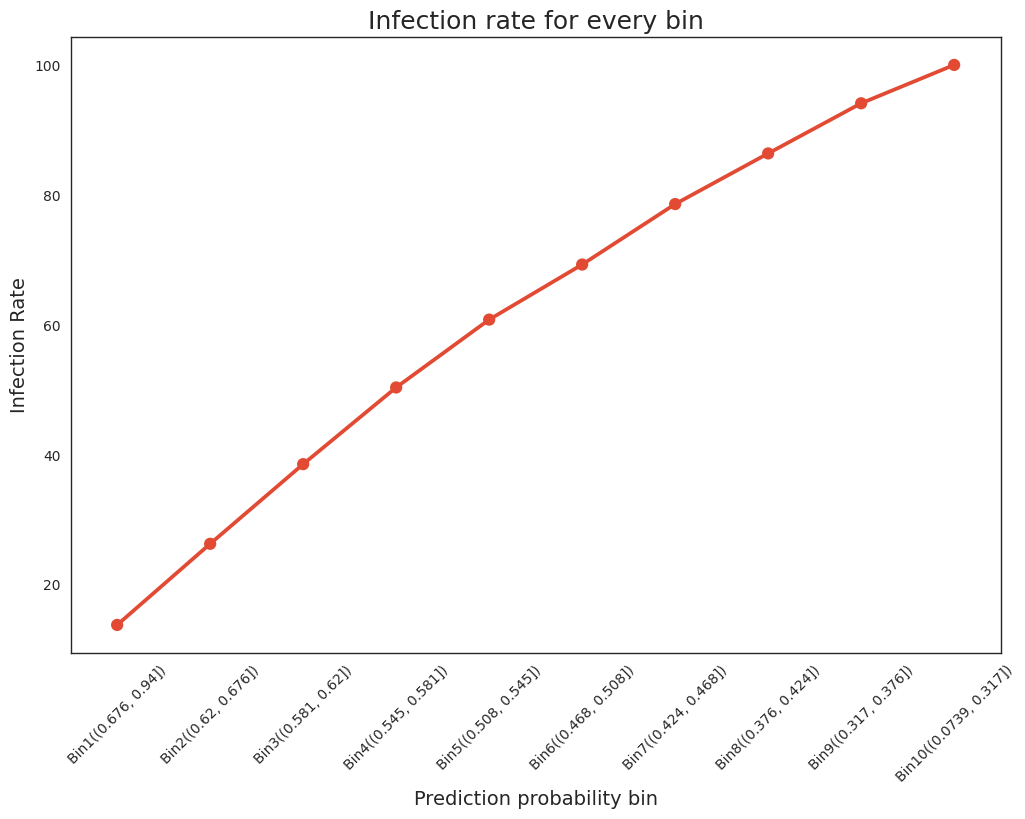

In [ ]:
# Plot
plt.figure(figsize=(12, 8));
sns.set_style("white")
sns.pointplot(x = "prob_bin", y = "cum_perc_infection", data = validation_df, order=validation_df.prob_bin)
plt.xticks(rotation=45);
plt.ylabel("Infection Rate", fontsize=14)
plt.xlabel("Prediction probability bin", fontsize=14)
plt.title("Infection rate for every bin", fontsize=18)
plt.show()

Ideally the slope should be high initially and should decrease as we move further to the right. This is not really a good model.